In [16]:
# 9-Compartment___Daily Testing
# Philip Cherian; 2nd September, 2020

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

Model details found [here](https://covid-measures.github.io/). Schematic for the model:

<img src="../images/model_schematic.png" alt="Drawing" style="width: 600px;"/>

Let's start off with the following parameters:
\begin{equation}
    \begin{aligned}
        \dot{S} &= - \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M \right)\\
        \dot{E} &=  \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M  \right) - \gamma E \\
        \dot{I_P} &= (1 - \alpha) \gamma E - \lambda_P I_P \\
        \dot{I_A} &= \alpha \gamma E - \lambda_A I_A\\
        \dot{I_S} &= (1-\mu) \lambda_P I_P - \lambda_S I_S\\
        \dot{I_M} &= \mu \lambda_P I_P - \lambda_M I_M\\
        \dot{H} &= \lambda_S I_S - \rho H \\
        \dot{R} &= \lambda_M I_M + \lambda_A I_A + (1 - \delta) \rho H\\
        \dot{D} &= \delta \rho H
    \end{aligned}
\end{equation}


In [55]:
# Parameters for the problem ###############################################

pars = [0.5, 0.192, 0.33, 0.5,   0.1428, 0.1736, 0.1428, 0.956, 0.068, 0.2 ]
     # [beta,gamma,alpha,lambdaP,lambdaA,lambdaS,lambdaM,  mu,  rho,  delta]

Cpars= [1, 0.66, 1, 1]
     # [Cp, Ca, Cs, Cm]

pops = [1000,  0 ,  0 ,  0 ,  0 ,  0 , 0 ,  0 , 10000]
     # [ E0,  IP0, IA0, IS0, IM0, IH0, R0,  D0,  N]
    
fam_dist=[89703, 180455, 314096, 579496, 451932, 289265, 327046/4, 327046/4, 327046/4 , 327046/4,  40397/4, 40397/4, 40397/4, 40397/4, 10855]
       # [   1 ,       2 ,     3,      4 ,     5,     6,     7,       8,        9,      10,         11,        12,      13,     14,     15]
    
lockdown_days = 21

#test_success = 0.2     # Success rates of cheap tests 

In [103]:
def Gil(pars,Cpars,pops,T_max,test_success):
    # Input parameters ####################
    
    n_E  = pops[0]        # floats; Initial number of infected, exposed, and recovered individuals
    n_IP = pops[1]
    n_IA = pops[2]
    n_IS = pops[3]
    n_IM = pops[4]
    n_H  = pops[5]
    n_R  = pops[6]
    n_D  = pops[7]
    N    = pops[8]
    
    n_S = N - n_E - n_IP - n_IA - n_IS - n_IM - n_H - n_D - n_R        # float; Everyone else, n_S, is susceptible to infection initially.
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    #########################################
    
    T = T_max      # float; maximum elapsed time
    _t = 0.0       # float; start time


    V = 1          # float; spatial parameter (NOT "N"!)
    
    #########################################


    n_S = N - n_E - n_IP - n_IA - n_IS - n_IM - n_H - n_R - n_D  # Computing susceptible population


    # Initialize results list ###############

    S  = []
    E  = []
    IP = []
    IA = []
    IS = []
    IM = []
    H  = []
    R  = []
    D  = []
    t  = []

    S.append(n_S)
    E.append(n_E)
    IP.append(n_IP)
    IA.append(n_IA)
    IS.append(n_IS)
    IM.append(n_IM)
    H.append(n_H)
    R.append(n_R)
    D.append(n_D)
    t.append(_t)

    #########################################
    W = 0
    
    test_positive = False                      # Variable to store result of test
    
    # Loop to compute results at every time-step

    while _t < T:
        
        test_result = np.random.uniform()
        if(test_result<test_success):
            test_positive = True
        
        
        if test_positive:                       # If a single pre-symptomatic appears
            
            S.append(0)
            E.append(0)
            IP.append(0)
            IA.append(0)
            IS.append(0)
            IM.append(0)
            H.append(N)                         # Every family that has a single pre-symptomatic is hospitalised
            R.append(0) 
            D.append(0)
            if W==0:
                t.append(_t)
            else:
                t.append(_t-np.log(random.uniform(0.0, 1.0)) / W)
            break                                     # Stop the loop if one presymptomatic case appears
            
        elif n_E + n_IA == 0:                         # No one left to infect anyone
            break                                     # Stop the loop as no more infections possible
        
        
        w1 = beta * n_S * (Cp*n_IP + Ca*n_IA + Cs*n_IS + Cm*n_IM) / V
        w2 = (1 - alpha) * gamma * n_E
        w3 = alpha * gamma * n_E
        w4 = (1 - mu) * lambdaP * n_IP
        w5 = mu * lambdaP * n_IP
        w6 = lambdaA * n_IA
        w7 = lambdaS * n_IS
        w8 = lambdaM * n_IM
        w9 = (1 - delta) * rho * n_H
        w10= delta * rho * n_H
        
        
        W = w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10
        
        dt = -np.log(random.uniform(0.0, 1.0)) / W
        _t = _t + dt
        print(_t)
               
        r = random.uniform(0.0, 1.0)
        
        if r < w1 / W:
            n_S = n_S - 1
            n_E = n_E + 1
        elif r < (w1+w2) / W:
            n_E  = n_E - 1
            n_IP = n_IP + 1
        elif r < (w1+w2+w3) / W:
            n_E   = n_E - 1
            n_IA  = n_IA + 1
        elif r < (w1+w2+w3+w4) / W:
            n_IP = n_IP - 1 
            n_IS = n_IS + 1
        elif r < (w1+w2+w3+w4+w5) / W:
            n_IP = n_IP - 1
            n_IM = n_IM + 1
        elif r < (w1+w2+w3+w4+w5+w6) / W:
            n_IA = n_IA - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7) / W:
            n_IS = n_IS - 1
            n_H  = n_H + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8) / W:
            n_IM = n_IM - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8+w9) / W:
            n_H  = n_H - 1
            n_R  = n_R + 1
        else:
            n_H = n_H - 1
            n_D = n_D + 1

        S.append(n_S)
        E.append(n_E)
        IP.append(n_IP)
        IA.append(n_IA)
        IS.append(n_IS)
        IM.append(n_IM)
        H.append(n_H)
        R.append(n_R)
        D.append(n_D)
        t.append(_t)

    return t,np.array(S),np.array(E),np.array(IP),np.array(IA),np.array(IS),np.array(IM),np.array(H),np.array(R), np.array(D)

In [104]:
def run(test_success):    
    n_iter = 100000                      # Total iterations per family
    n_fam  = 16                          # Maximum family size
    days = lockdown_days
    # List of arrays to plot result ######
    fam_size = [] 
    fam_i_risk = []
    fam_h_risk = []
    fam_r_risk = []
    fam_e_risk = []

    fam_mean_i = []
    fam_mean_r = []
    fam_mean_e = []

    #######################################


    for i in range(1,n_fam):                         # loop over i (the family size)
        time_survived = []
        no_of_asymp   = []
        no_of_hosp    = []
        no_of_rec     = []
        no_of_exp     = []

        for j in range(0,n_iter):                              # Run n_iter loops with i as family size
            pops = [1,0,0,0,0,0,0,0,i]                         # [ E0=1,  IP0, IA0, IS0, IM0, IH0, R0,  D0,  N=i]
            t,S,E,IP,IA,IS,IM,H,R,D = Gil(pars,Cpars,pops,days,test_success)# Assuming 1 exposed individual initially
            time_survived.append(t[-1])                        # Take last element of time array (the time survived)
            no_of_asymp.append(IA[-1])                         # Take last element of IA (the final number of asymptomatics)
            no_of_hosp.append(H[-1])
            no_of_rec.append(R[-1])
            no_of_exp.append(E[-1])

        time_survived = np.array(time_survived)
        no_of_asymp   = np.array(no_of_asymp)
        no_of_hosp    = np.array(no_of_hosp)
        no_of_rec     = np.array(no_of_rec)
        no_of_exp     = np.array(no_of_exp)


        non_zero_asymp = no_of_asymp[no_of_asymp!=0]  # Consider only those runs where there are 
                                                      # non-zero asymptomatics
        non_zero_hosp  = no_of_hosp[no_of_hosp!=0]
        non_zero_rec   = no_of_rec[no_of_rec!=0]
        non_zero_exp   = no_of_exp[no_of_exp!=0]

        fam_size.append(i)                            # Set of family sizes
        fam_i_risk.append(len(non_zero_asymp)/n_iter) # Total number of asymptomatics (length of non_zero_asymp) per iteration
        fam_h_risk.append(len(non_zero_hosp)/n_iter)
        fam_r_risk.append(len(non_zero_rec)/n_iter)
        fam_e_risk.append(len(non_zero_exp)/n_iter)


        fam_mean_i.append(np.mean(non_zero_asymp))
        fam_mean_r.append(np.mean(non_zero_rec))
        fam_mean_e.append(np.mean(non_zero_exp))
        
    return fam_size,fam_i_risk
        

plt.figure(figsize=(12,8))
for i in np.linspace(0.1,1,10):
    print(i)
    x,y = run(round(i,2))
    plt.plot(x,y,label="p="+str(round(i,2)),marker='o')
plt.xlabel('Family size')
plt.ylabel('Risk of infected individuals')
plt.legend()
plt.savefig('../images/Daily_Testing_9_compartment.png')
plt.show()

0.1
2.629824685597515
0.2581596648865305
1.8200237247276307
18.31258705310364
0.24240962365665086
6.249276991160708
3.318751079600035
4.517421147244077
0.6846500431806067
15.99463975215527
3.961479256874337
2.4952094605444097
4.084299493003786
8.117850386604907
4.1142552330517
19.696620692768278
8.893503956300224
17.117002913754902
4.879583505157183
4.916222303300544
1.1502295272179188
2.099811679784465
4.043498661554672
2.1595151145190172
7.769964890069896
7.193567656340762
0.182627523828124
16.96823696873013
0.7398861433010374
4.716724378945375
5.893116775930153
2.211366474337245
2.3871502335349093
0.031820669035921664
0.43129347358466147
3.8442095122271267
2.6651246365557455
11.282871230014676
12.467136396964554
8.16195194336711
1.5788494557145087
14.840768734958447
3.1281095156740184
0.14072173185690787
0.0559591208718815
0.031098283499293708
11.49681005518921
1.4591153397002325
14.30834820529568
14.351544387056979
3.011985978617196
1.7393047977781337
2.1025888466203386
24.28942106

3.708571175352208
1.1919250584407117
3.200653018874479
6.661287356636102
4.591047970788
0.6472567082719152
8.63028581414046
1.346361154745478
3.6288540008166006
7.565209241394315
11.859529881557302
2.824660938218395
4.27586396509296
0.5241894229162672
3.372894863651773
5.724948225698213
19.559785422716452
9.951652113334896
4.273385398495384
10.641262451538186
0.7682394680967969
9.736462432127409
15.377016890348866
3.218684695466295
11.534962889519374
12.703579493613908
1.4925703759964946
9.49331818749487
0.9819413070472589
2.6952650994982204
5.607979245629662
16.893198600104576
13.021492500660932
10.611310575155104
1.7041691629525324
8.865816545853383
0.20937521247108792
29.057755338456786
0.232574323644143
6.576039967094701
6.21684028077326
2.142769810555306
6.38483980329768
2.2857579863322446
10.64347262536509
15.238176559776694
3.1604635140212096
4.550403484877294
5.719472323258274
1.9539349937547175
7.179525581056978
14.71110521269547
9.929795704161856
1.4767390019191862
4.69699649

2.7849551564916184
2.8650320756332333
13.005647665028073
0.6716683672354313
6.221951267506787
1.1571598495707176
4.924955053028449
10.255593069821735
0.7917728018924907
13.802979455901209
9.654195034403974
10.92653729437554
10.554749085312364
5.646834237897401
3.911950230843363
0.7555972519139109
13.410428000040827
15.482509445561163
4.183833154691465
7.159066924640876
1.9794319133437626
8.369174005622135
0.3696326209725872
5.732823646136069
9.629030304604491
0.35647078846395186
1.8186178052932072
2.0283826289693163
2.2420933419106386
2.453888255012616
6.101670249759249
1.7965617166570471
3.1046062961912297
4.335207183313525
17.82995188392059
2.2280154617007746
5.217833845778893
12.560317546642672
5.822942856923328
12.47044918430024
1.949451339292739
0.825747357170642
7.636558950798293
3.5963281601098536
1.2296909882394873
1.6888979299790534
2.831994868371772
6.523735683173234
3.8844558824473316
5.75940095196315
4.535499730509234
22.980612489379418
0.9865020077404416
17.613206741569318

4.804773542731403
2.025285264807028
3.7345606085093754
3.638052712571052
0.841117708383008
5.627409937839842
1.1775223299083617
8.173066517595503
1.919248960735375
0.8650851195471674
4.134665319577079
8.43678540788233
2.8509699936941186
5.809466307734647
4.510976778803377
1.2982274908237033
9.369003788657661
7.110658987605503
11.356601628391333
4.32231135724789
0.49198268612373397
0.5958780289407344
9.219830684967253
8.507805853970785
8.900445575126696
13.131341241519223
27.71545466188971
15.246012848128219
4.9167008814430595
17.346617740643538
26.05381741849296
6.420303556893807
7.536440707045313
0.877382986075291
0.05423055224206698
4.817967206052511
3.059847694057409
2.6825018054920973
14.924971642250046
3.705882735226638
1.4412128561711086
8.914894341126864
5.875147920308244
20.215693153860613
6.575037540379875
1.2708441810216058
7.602567006261649
13.497555016572946
11.900892945686017
5.079665842916219
0.0500698108149118
18.313855282613993
5.523521404626343
6.18102548805846
23.3083

8.524605882909599
16.073331065127068
0.4880769788524898
1.3793726328300695
3.539358364164111
5.347601303422291
9.526125635530645
0.8835853637247908
6.57164182515821
3.443608849443518
4.291374680972139
14.411934341287282
4.423094090499503
8.555111979942675
1.7044928520265077
8.112016627803513
2.318722759552565
12.346732876525325
9.157470913789826
4.637724117392169
6.38318538766807
9.4958895966186
4.353100352812158
33.64791857591436
1.0477272955958576
26.63917855539122
4.265925800685847
8.78487274798701
6.98228839468019
0.9386042920672266
6.100087060457659
1.0158206990054286
4.943455446689668
12.12742902932995
1.044111222527359
5.604149284737933
25.87153056914938
9.972638304198078
15.382214104607435
4.162013160827638
13.559339164357844
8.426228309221717
8.657156463609272
0.42337052059838015
6.0470597441984495
3.5878701580225947
7.489281210648459
1.8933567541884773
21.591957998779296
5.722360006053043
2.955554933744338
5.551707551617878
0.2080271348816472
2.7513592184007885
3.271580673860

4.790622424229997
8.388644078434906
9.90912857268574
5.949581523362278
5.73440387050176
2.481409313232438
5.5781260564164725
3.362388530679162
10.660285998651434
4.076406784752411
2.6329093168322086
7.782171323150259
7.816014230459864
0.4054460655075221
4.025190484040878
1.3060701840598439
5.334537579274469
9.490101873442098
15.779484843087198
2.7972108053166425
8.590017531133265
3.057567623212808
1.8018181753609686
4.56107357115071
2.5424940471157877
11.437021251136981
0.3334253722196475
3.451807493039912
7.888551732678654
0.05457614412018326
17.103013047356676
21.14334097311986
2.2217499609331766
2.047908499167431
2.310867446965171
13.514356616547651
17.646843035605798
0.10660244704047074
0.709447740541719
11.14643759427544
8.070772380101756
2.370724785098673
0.9843092489539524
16.823521511707714
2.598195756443132
7.35842001182035
0.6476935227822416
2.4281217214892847
9.730692602207542
6.080609465688336
12.22371439249141
10.429681759407211
4.429411055423411
0.00582758458161047
8.5832

0.43138851254636085
17.754111278678593
1.4447378684423247
1.1213710401973427
3.509090363776249
12.439001101797313
3.7035443814630655
6.8008015362394945
4.4310323639296145
2.436746000968455
4.014597028532987
0.3496254523900462
4.383226903220021
5.423282005396623
2.1855571829882123
0.1184212093738554
24.864809748426794
6.342140522129357
2.187534757769506
10.016853806645846
1.3222424989724941
1.8928001265954382
15.08273306435007
4.783422925443239
7.950630994562698
0.754707423462743
1.009067474152753
7.511962557593854
8.310911032629694
29.091415200244825
6.162416091840867
11.70918908614205
8.233580774852891
2.804558254935446
5.007818496956052
5.4793885664690185
0.09477572352460238
3.2687908258394094
0.3711890655996763
3.690243694610506
4.559055570492557
0.24179034971748808
3.168942934114389
3.0410414777470405
2.300873494233959
9.056656897761137
10.004989890856098
9.19132060777758
1.2209265646623833
9.499491627551285
35.615135245496326
0.5935589125043291
5.500785241155617
7.732893610932109


1.7230518876076084
8.101149632974762
11.956067248097003
1.424221983257431
1.3296629307139751
8.10961949693692
3.2848034815601546
4.586145314744619
0.24896186963319367
5.850087150782281
1.0151902345132258
3.3658928178356717
1.9131424338086405
4.160260024029325
2.009628934511197
0.5883815705914457
3.843482809614593
1.2184241672572484
1.474599157783609
4.970787929109956
11.914156852520202
6.370986229658463
5.965548352058094
0.9631446431686025
8.894648296875731
0.6991964604147812
2.548424771260668
12.636658274179208
2.525979797902191
1.8719012065714462
2.4079455118206083
10.496424757601368
1.344129421082131
0.007008022427352067
0.7146739891742035
11.071118130385237
3.0577404207614554
4.972618855885654
2.7255876217880135
1.453871007690589
12.118029469094376
8.670815397793774
37.73665433522494
1.3369829149676908
4.617643854596145
7.367069328502774
1.5499974378679768
12.918395824425978
0.08840718392002112
4.188147970967922
1.6147243192756466
6.1833239121321455
13.52176376542494
5.189382719873

20.054169587144422
2.313421232492044
10.302110254010923
19.752217208831347
6.9061653794681845
11.411226154953606
3.6311896821671548
0.2530508122359655
0.026958607756612775
2.712496386778437
1.5966680535992375
14.227438629845444
4.79225784053774
2.3960223223788337
6.731118450894792
21.15694675650322
0.4840131086774932
5.333729719883856
1.1384734200053803
3.20121447095052
18.586585263332722
15.336213614017682
2.795083196632702
0.36461217010305874
10.169674208473575
0.18177222506528176
8.706003726093773
4.3016928283080595
1.3273779913362225
4.239208155028945
12.126861902177103
1.2286941274883911
10.263502030030164
10.337573829987516
5.2660419922085095
8.334523479824595
1.2343557627537336
7.291341991378544
2.2477461567854675
5.309474246944989
6.37448062025187
8.839558789989384
9.75462194539179
0.4736739437564884
7.7425312335503795
4.091276573486462
9.092248627544183
0.633164266708819
4.787445771206956
17.05759469408678
2.0688072515252114
9.256257273033409
6.085490516625767
0.91237777419244

0.6885502979307022
2.028697655144638
0.41361108001612573
5.918498589936508
4.578820009242211
5.384001591413771
23.261914575706083
8.447452366336776
5.068421682651776
18.932546531777042
12.283096131740797
21.319433800284067
0.581873141884076
1.4047918969441506
17.84718386312612
3.884884989310791
0.9031301865548229
9.571055912464674
23.839205033810007
0.3437029702602625
1.4295896806062933
23.377831325666826
9.494763016509939
0.924971595885263
7.435364594615077
16.005472019156905
4.059710544245552
14.023356818877073
13.173455724863965
6.465853311196248
5.456951478605111
7.075810457436212
7.586923747554621
2.479218646337318
4.383988718116313
0.9953632709281967
9.315873510220108
14.87727027008004
2.3285690229122267
0.08448876486042013
0.914954247874246
1.536176602458339
0.1070888961805612
9.664612729284547
24.155240791192824
4.180837861212051
0.16525630781081854
8.660941953076398
9.240909223753867
3.547324948946335
0.7767652046889802
6.9768000343300285
6.778952922969427
4.606462856202685
8.

1.4654857537869903
3.7741725780663304
7.660962310642045
3.2968001993659115
2.7189645661987347
4.389693027285862
8.741599185212001
6.133218976387772
0.608795694574261
1.1778874309718104
2.8091139745204314
4.798739193939129
3.146631696369009
7.16881952917258
15.480941979187733
7.407350768245305
11.818821893342221
0.4757104846648686
7.841441743321426
11.654199597521952
13.392949510777
0.4713848515636914
1.1324301644847445
31.653113273686916
13.670459055576329
16.248372548073277
2.3553642329351763
3.225834852383692
2.7739350891717716
8.995597502624666
27.50996397246028
0.6596509099366208
5.6033383406251405
3.1492900110449815
1.1634257759198285
2.0322995001367614
25.64685255966338
4.560999987893959
6.1063350572842525
3.1893779073129664
3.198442988535316
5.308968563663506
4.035794936571205
10.66417128392692
1.8216831866420167
20.097860135247814
4.6253642586976955
0.32476757873114565
20.010469597198163
2.558063325493247
0.20714042451404976
2.0655875169896123
18.842162853841863
0.7640782044241

21.63221205007727
9.942912510079088
11.424148494178336
4.349545202342955
6.976292796754753
1.0241759248464428
4.259961291429908
5.115537203554737
6.797422995725157
18.36239688100326
35.02818836642311
3.7968848539504108
5.398669861557753
14.705785821820283
2.881529263612464
13.131907401866187
5.102188954643307
7.46569905813895
0.24641557971921685
2.122480825658855
14.88330964280713
4.812756041920635
11.923474295047182
1.4006946939768945
3.148810999092085
0.3367316248364988
6.402258387951917
4.053475942717783
9.982093559439145
13.776815526168317
5.90612664730927
14.108045572153133
3.4418124112601967
1.7162501791944589
0.3382309182416531
21.573265662985907
10.315308014462005
0.67347707775379
4.032902890009892
12.230337592466109
5.327468929552489
14.579309880137263
10.735724133971281
0.3759928135116782
1.2877437983482765
3.219708387948455
0.8960177811903083
3.5496630202576784
5.852272101595498
3.2084769438690754
4.4627373805419674
0.8754448953811788
20.713714339653293
0.9995188262964629
0.

12.625201432967476
14.680211578938728
3.3993820322707213
1.9587911584687467
3.0644655360302067
4.2516077098932294
3.239279356359855
1.1411108525935798
5.895786546766559
13.387067503602365
14.908501335729294
1.582174463206752
2.4745284439082953
2.8615868919747665
12.208799103673348
0.23150624948802312
0.009736516925688405
1.856317541195935
4.748520537807651
6.724576763920314
3.579532091812799
4.845552688056994
21.21532841553737
6.090388779391755
8.364855652034912
2.81912575622945
8.442209322316375
4.371006717768303
2.393656386691687
13.478755205889149
0.7306805586294871
12.08314286354164
33.50455543621822
4.586718978518287
5.6750277772234945
0.29920733657446874
4.20514532656178
11.69891443640996
1.8514527195779085
5.2126511946307295
2.1003578262820084
2.7189348937959523
39.490420213528694
2.581113991009008
1.6730460636694608
1.805065354198711
6.852528521356051
4.943919512555514
4.353278461627931
0.25490943172677316
2.8931635404767304
10.654275261722828
13.587118615686968
2.3105144229238

6.057802388975055
2.769553430488701
7.821265415769585
1.7215567005181005
10.941125625731138
11.607646988599544
4.809755217785096
5.575952090476787
1.7632137105875794
5.751229880895122
8.658970483404671
1.379493207985717
19.383788390577443
1.1582834342315902
1.232657554277315
5.402814472494921
0.2584735945303134
9.335254961436435
0.46429814455539425
1.8058198493271438
7.44616188015716
5.784829623820203
13.25821186398478
2.364404147422211
3.2656321156084274
3.5226174152293126
3.5180031216981775
0.7156166265374431
6.068594775711889
7.7989335797736254
0.7928885613648081
3.1574349648151756
0.398778078844957
11.982486092049687
4.56016916965284
2.190380621323495
7.631353158722412
0.7220102756515084
0.331097272145231
4.626618808980508
2.8750024020332985
10.093961658856221
2.7216738715032682
3.290172891949843
4.370142846330418
12.878479058134793
0.054032054813913245
12.567235664138131
7.092977886157998
8.929021282530615
25.109975245556324
15.356187279444176
23.991371109354603
23.813148823443804

7.519825500794899
11.615690988365083
6.000678457655765
18.982551460601364
1.3572416844962365
0.8739463564890065
3.056698058832878
13.521807255199711
2.5009678079406115
4.418523977644059
2.4095884953884097
4.28127190954795
12.495594629693143
1.20660536438828
1.2277797771312893
1.3469437378592009
22.830449965026837
1.9077692682442928
3.237428526922672
0.6209712726316277
2.0187287616404066
2.316869508181991
3.952800776185279
9.995898679197962
1.5904603787007476
0.11630215064409946
9.222628573777241
5.210891884238406
1.5027938063110655
5.185510456577125
7.827021091323451
15.417338881724032
23.874482975498715
8.62996232488788
13.993134700750783
1.2164361910152053
2.1490363649685458
0.3450062621280573
8.528556769985602
12.439346541051236
4.8436891141121325
0.5472482752548585
0.5594593145092218
4.603448473602165
17.349473701500656
1.2172866510143303
0.011532391854212865
4.595564715338417
0.4383943641211603
7.079872357197301
0.5094113479805036
3.634689000984321
23.96894261216923
4.030734596019

8.71366422195293
13.067745845473675
19.17223406886966
23.024193152491744
2.8078368094208566
7.737107260516873
9.007911885143976
0.06895105965312197
11.619674442192904
3.856937389278187
21.612413322294135
5.159970920352749
11.232540333225526
6.467635824970935
21.406287210391067
2.4773978956675995
3.6616134576575003
3.226940877915704
3.931458855895414
5.508229745779973
3.7269890240301122
0.6074170659294871
4.824497265974639
0.21893260973476628
3.871923902644089
1.962637829989283
2.312116703192965
0.407876371861151
1.4168667907830326
1.9286103146077003
7.559772901904621
18.221936986868485
1.6334517331901401
0.6157511874318015
24.422587615826828
1.3370350097988173
6.800032414311116
1.6655708776916138
13.22914404811344
2.9852179444814055
5.106491101257533
0.3835961387664756
3.820597205639339
0.7879717485530875
10.745220269027167
15.341532058113298
1.304795280043697
0.4163908711797333
41.12666670783516
1.760202241719102
8.525193289695826
0.5063478543913991
11.489431392890875
37.3712371693679

4.203542412582555
2.265062902822605
0.1025472379929621
2.4352569116233562
0.8504323498658783
0.2181984649427607
4.027567296565735
10.157693517496318
26.437457025596494
2.720655231914476
28.337743942525023
2.0972835324228387
0.702565874416162
3.4839346323074114
8.649911522598096
0.1129700769133767
2.877401006247112
5.3911891015698075
5.711535866345488
4.55195776525297
6.480137932270838
3.0993792801428257
5.567672273533526
6.028850503890206
2.7627354781651876
2.8247415669805593
23.964691043126365
3.9843121688404834
18.05550123148504
1.531751871305397
15.051252757005766
7.1341207153837445
8.564870582992471
19.92592972145954
10.162419308239917
4.614017708206694
5.519550768619256
1.6480745744472778
1.1816615722135102
33.32933055797543
3.7145475387685387
4.57536437568827
32.729686670401904
2.807335573824105
6.537870072925589
0.8899974430855978
11.061391996014628
3.4206752998969003
7.151075943212697
15.97298398291013
3.3338118252493683
2.0449082570716715
11.232790339976809
1.5244456906733765


3.107674005861778
2.3542332925083516
3.2369478394681046
7.341512434698595
15.325464269868878
0.5859839738306388
3.640864779199845
12.60385653779103
3.381085458862309
11.396468064795759
5.444544075017794
2.9294255227530726
12.579302170077925
25.255458647903847
2.838753683652605
1.8984925636665102
5.814561199885737
1.645761626024308
2.5579482007700207
2.6857787688602914
9.844024749044793
4.667734516590455
6.5312737889107115
0.7828043865978493
5.0993049099219245
0.8512203430790651
1.9710917347184709
3.803985042762616
6.05362935647222
2.9339615565004427
1.3207497548790872
3.46597484233852
3.076969293792814
6.051761832739524
8.818384200280374
0.2824056355619173
1.3536813239373682
9.495022820671029
12.06029202236406
12.093268281540128
2.82793216115961
3.2754813847390745
16.47111127382325
3.8995116744969534
4.66048343093447
4.981492647768927
0.4469352760234279
0.002165024201488306
15.056165739364015
10.045061473333915
0.6445362304485762
3.7726926364643596
0.13280411317865676
1.554604677405343

1.5716408839402984
0.4068803724237835
4.5972280522412285
24.601197089434606
0.6893542015960498
4.468092358399327
17.25102496862756
20.706962610551976
5.236984468761877
15.191845748116977
21.525671675945652
2.0678862122081374
9.467224366647965
7.283451481464988
15.497031030076442
1.7748629304001888
10.846415319517236
1.7795085668288202
0.18261136658156046
23.28709891791502
1.9686843304808943
2.8041542143167013
1.206674177576345
1.6769658911829715
0.27922916690541694
5.4902181654072875
9.66113775256234
3.2678493394274173
8.729744676030043
9.628017569080425
3.9526895136488918
5.26825540339078
5.975721021257856
14.331962622603372
3.719388195281369
2.3864135639777477
18.300040875707033
3.4949652126428608
4.550870479550053
5.1871377846422755
6.152720317009311
24.50213151437229
2.199350122703062
19.570062759481335
0.07619968041038466
5.965062408943733
4.755991116338785
9.187872143105904
5.794716321222837
12.423168806140941
1.8561221983983784
3.5975240180556893
6.153141344871134
0.349717497080

0.16304703896591569
4.1675287726125685
4.689689564368477
3.4796176326131056
22.069712552257197
0.6812421806962129
4.80077985692693
4.628071498122235
7.378401232532556
1.7319600983586019
4.362760172888019
4.452337254403484
0.7964960400628771
12.334034179540376
8.157568531016626
17.381428059504056
18.748481653316347
4.988218851121789
2.030531994905053
2.5972582078118007
16.743058089790818
0.9357147080139114
10.190103252195335
17.546722995818886
25.909895235819263
9.573855732065523
17.377389020621337
0.3079345483843735
4.507886796256233
0.6176984165107227
1.1667085636454575
0.9975364091688133
3.0862102398184357
1.869550017561139
8.793068239677572
3.1573140130225803
4.577624162340745
15.294158812455715
2.2852850439398176
12.819506207529187
1.8530415714497066
6.470612300791862
3.864453919954647
0.08714635014587135
8.09060500242354
12.317320007333862
11.02253859304022
2.6365489458715725
1.232864431102287
12.128359494095239
0.0008146070051132453
4.572386638810584
2.2585443130348537
6.08657842

0.08035587634154302
8.368592034202512
1.7162273406961863
1.049943050913481
4.506728835131816
12.380861538399937
1.0675547807444947
7.308956294215125
6.119811160849055
4.337372397072588
10.125619367839892
17.47261301637426
0.7616858754825911
11.350438780352233
5.485317761727163
5.495338671518349
8.15308329549165
0.32190133113513525
3.1946595315410877
1.7581659172074502
3.6948295655410464
15.882834151656748
25.448245732348074
2.9797778504510157
12.773598093165303
9.492072691875649
0.08249797548057017
7.93788357807281
3.025698706518685
1.6640786714886242
9.282469113161286
0.5294745618614365
2.7159848921593155
0.3575312341671121
0.6362502715551084
4.349351224283876
8.181760731680612
9.476106299959474
10.185033064456688
24.34054623573561
11.476463035602627
1.6917800853980358
7.834057045940364
11.999840500837017
31.555198539382207
0.6954254265620111
7.719016519286401
1.7899248267253218
1.4265348050305948
2.244925985556803
1.9698738009711594
5.522309784282216
0.861078165167922
1.2273337813515

1.5576150354357432
4.185181476028664
0.12285118739312935
3.498728957755087
4.143773236420306
27.86198454539634
4.139089428973859
1.223163883899761
4.705958164890013
0.8100475596309691
0.600016940977456
9.049228199604286
10.957257051865113
0.20074477167999938
3.0006433015200513
0.013364083421003101
1.1930251861385381
0.7902484651032511
12.667341371618242
8.172608519391934
11.175937173698122
6.9952726344297895
11.916632201572353
0.4421557336042489
9.342315816748778
5.892279390273673
2.944403605053986
2.4664174483115024
7.64051558301378
6.923529063507683
8.888558939673967
13.100724966417953
0.7268560066297587
7.250811171361719
8.645463629358124
0.6303259809884009
5.561069421713876
0.05790100760589197
13.680461085034121
4.405409681658949
6.4464269957925
3.8822135731704637
22.231416753839902
2.502119569262494
4.631213023158971
0.6543405514617946
9.258937357370952
9.656528786135388
0.5971904505700102
9.136137345130319
5.029255697627972
3.144984177055472
3.2555094029499876
31.03802557855671
8

7.87235808823772
0.5567992509667284
7.668332119320689
4.852650783675773
5.027224871483163
7.873380808520679
10.031378760772249
20.0325607928526
6.936774286528018
6.238789007166729
8.946599166934309
10.796001228014
9.760786918252254
0.026762505736357262
3.590883487738351
4.945209246104815
0.15263935632005018
4.340003540020695
1.352559153869361
7.225789217415111
4.8308735375893965
6.949468697633331
2.5134500794373404
7.807674941772383
0.9400656620068648
1.8469466073001446
0.44024216136285976
2.811522034905309
4.072243448117623
5.1940365975737395
5.929195598915091
0.6875559137788672
4.365997417043909
7.498382550649784
2.975032499599824
10.566592466197585
14.691454417208668
21.34852177188833
5.00314998701834
8.856180918735017
7.711066151968651
20.094815099849033
10.401759083500048
2.717531570191715
7.047581992525835
10.823182913649184
16.662638928725926
1.4576867202324462
4.47790675295328
0.5701914702297636
1.5474774815828725
7.909075126955127
2.493635601517836
39.111585856842844
6.3075345

0.7675923002919325
5.412659531524077
2.996919058784339
1.4698559359628445
1.5817736307523773
0.6721751121257146
10.85995039916578
5.246145334976713
6.654843256717075
0.05856014844781768
6.884444744026189
3.8370695906212458
0.7449351741391164
2.4958635746341775
2.600092380438788
1.426200495388723
4.773001981187053
0.7804217142047009
15.877920831920205
4.852311282179787
1.9409308202824704
1.36799809191216
7.1960051533151
11.17343464317737
0.8026140806834555
1.4094972390808438
1.9790151848250461
2.7362738304738103
7.186630825132283
4.293812971522126
2.94126338024602
5.8456619438296675
1.5469048865386164
11.698289255344369
6.062426804772088
2.0817088765834932
0.4888414063441281
10.456139863212767
2.042761728547065
0.32583640773498584
3.446096460464363
14.169312041639408
10.047320130880085
9.37072323253394
25.659068968803123
4.434448713332583
3.5156235867219863
5.538135295573614
11.992100322930934
8.580695961352196
2.859146191202388
10.868523906133953
13.494932265111046
7.342725445467581
0.

9.652625942988356
13.420005634805028
6.302225934055186
46.44186257681596
13.90670873296501
8.922729645128316
3.2650814350022466
8.84058574473307
1.152020036135948
21.17863525505632
0.33136594469395364
1.9576069047433522
7.575951409987191
8.857784237502091
0.8160652645966415
5.7567573743680756
10.951594418115247
3.699929612125177
4.017383922917931
9.455799423768699
1.1938787579405683
5.493418766165014
5.769469623664661
15.797888457633274
7.614219232914695
0.8967222383505342
6.283459209842419
32.83441001139023
5.946568464266449
0.032148458172390496
3.703282646506815
0.29272815571775196
1.821357988299575
7.129193819365373
1.3146043655470336
1.6865410345505216
3.979048723029947
1.0872123234051316
12.858488447966103
5.14073462485134
5.39533578274116
23.198151712814944
5.381827194593746
1.8337616459580075
4.280547976501729
4.300907651460761
4.589582971716697
2.1997267985945803
10.310475470643661
8.856424743416506
9.677462811849653
10.642285241578032
3.2232906756628195
12.901928589880091
1.07

5.728909409585396
12.732767602943667
5.631416055613451
8.078344305347988
3.2216096467614155
10.435525057221017
11.922310327776938
1.7149010443648305
4.083823267357515
2.711668848914473
6.421588469490117
7.420720744113122
3.5193653749338965
4.7179623893587275
5.704996635351337
8.419679438564224
0.5591759262682958
0.6514403117483655
1.025399580489181
6.503863899997489
6.515933583091198
6.098008011858455
6.522426428181637
7.736683047383687
3.6081105664498705
5.784089901859618
2.0249266812278712
10.059622899491355
1.1919407787600165
11.563629288575699
3.827201948514722
4.296172482083204
13.752390952289275
30.57060544554925
4.535651011860484
6.804098421939987
5.093530828785026
9.183160798931269
0.886895024358346
0.058459797850884454
8.258736955393251
10.151271678203003
11.434208031019363
15.337899465877793
6.859032926782862
3.355486085328919
2.1411501799244492
1.2511415666894905
2.129344026761124
6.8609078877445455
1.3964989876633922
1.5707831866303321
6.625849460317704
1.8616944692044328
1

1.9227453365460438
2.9454461028672876
0.04319367190227597
3.4590013393569503
2.8793831543227255
3.0987104212135526
0.6444507852599749
1.4710477924618077
7.28632435355163
1.7937952748377683
6.082729733176584
3.8486261276264293
18.065498739436126
5.476951551809765
0.6458457816989904
1.7036707190290616
3.4494139368735706
9.065748856983266
9.471075944836818
2.1027179538844387
1.989525770474836
2.0771021718727907
2.1742003631693394
12.162423203053315
14.421308254396147
1.8945284033542802
6.354875387430702
5.9882366437178804
4.2388042827321115
7.779980877315715
6.027102835525391
0.6224825958439876
4.491501797953345
0.07475913201411254
2.839934795533222
8.403268829383967
9.415532359114813
0.7495817973941556
2.3422752435624417
20.471464618933215
17.566683760104475
4.333486591318552
14.008942618211455
5.00624982260381
5.164140084974523
5.328364785303263
0.14249581041403395
9.378019382626599
16.16648682928944
0.7271442960027719
2.020813502973123
9.809674960644347
12.60283392566534
3.767797718409

0.6371631248377554
10.027331574660542
20.098247960080002
22.74607404388011
5.232934834583491
0.12489857332521061
3.8432510434451403
25.265085339320837
0.2888439144003696
7.41765458169491
16.241667106073088
2.7476985638419498
0.11663573553557063
0.5113404758538849
2.74843795913359
2.5858222626610488
5.92685311269548
3.9264608513273687
4.789989922537398
7.758041306360587
1.9758210122782982
0.17762845695899052
0.6122462391992323
5.695297379812974
3.027893328543823
1.86533003222705
0.8342317389165469
2.2397785237362053
10.323861682262645
9.13395898168412
4.8845510263808105
7.139614220271134
2.5295120746470925
4.831377550755485
17.856547914106468
3.220700848614903
6.311317654632326
3.4262394569494403
5.026391902056919
6.532838078526067
4.864910343808996
2.8063217001060266
5.119423379828584
3.8531651894640864
1.1447624784249029
14.107522238283904
35.4872162442407
3.7766722182472106
9.45981836714818
3.706087595383766
14.964496480286588
0.2585762820403378
0.9728334063943892
1.018327609373754
3

3.2080300981986274
4.604510346613579
6.183854316262467
10.939689107849079
0.13777722188065714
2.365967096351851
1.792444463052308
2.1978683593415655
13.334283404399404
5.093188673023941
0.961676861643352
0.4077449003008841
2.9343033038555144
2.960463728092803
14.023342115491417
4.902570285895948
6.777875300078851
7.5304222497333955
12.039988835943124
15.394756102064182
10.804501718649945
11.02792397980646
1.3025154282825346
0.7750004996297886
22.250731313023984
1.9895416031679578
9.812524283416385
11.412755879746843
4.804713272212206
7.993123125292241
0.6399402299454325
1.0230318048651705
3.6630864509853813
12.099558962727677
19.57867951886518
1.4522416955765554
10.546578362023302
3.299420347290001
4.396103283359492
5.91868612547961
9.960373256920683
5.444518915520428
4.620041182360666
8.085817013526453
12.368806585211917
0.9326134810893373
2.65747257504266
5.676547212869914
7.147874118003402
2.821195042570951
3.156960085363299
5.0594102408813715
2.2780150330571414
0.5880442495996714
2

1.861256799799427
0.9282051417999072
0.5351008075476722
0.48782032072929254
2.9365012726805757
5.106376543146524
5.367133860117377
5.382489712045068
7.189107219468326
26.121555445794
4.1842878023243735
1.7831287393736153
5.450751721976163
5.6902968479044835
2.878869923998088
8.779444652825465
4.191558507392838
2.242870334245339
5.677706019539491
1.0957263591485058
6.157647180705876
7.513745788521572
1.5660624598188848
11.032953491462031
10.016484960124036
1.702153715900434
1.8949142117298299
13.763281090233516
5.186061519776949
7.173335053003876
0.0841426407266956
6.787612225827567
7.601716605165612
7.753160800971103
11.547546004657463
9.931255551848926
18.125314402179335
1.7698834077224557
4.467809117478677
0.3562543026886032
3.6197847027044245
1.1882353218900599
3.389512148753005
2.0426446754852248
0.14858141733956556
2.519727499994686
8.35269805111228
44.24605586589084
1.7122020409533234
1.570604499918606
1.0013198941260848
1.0318730334806254
3.2806560775822153
2.755345671839674
0.8

5.7536181255388525
1.8659868014833472
1.247437595979079
30.034716574093814
1.4622209798351375
2.0796441000042463
7.43528049235387
11.606518429462945
2.778695007003981
7.128546401730537
9.002285492245376
1.7052266141453865
2.3996457866244607
4.0296660703383544
26.73522095052718
0.9616164885671222
2.456804795925021
2.162270737841832
6.27785303859043
7.569309516867857
1.2393939352879637
0.202590503689401
1.5923499903158715
0.19346495897547103
5.449493997004
5.088399840792352
6.886124797438004
0.10835073017239781
0.4098333690998315
2.830568999470087
7.354765121531511
7.278470559466319
0.4218918391258389
0.4646801401867652
1.9468854547879952
20.29445474775527
3.1519850274387857
10.019171868701397
2.8592797719659173
21.964912928538755
7.144481613641168
7.889338437674964
4.21939741027388
2.55153530891457
0.5915803489777662
1.872811179135076
7.4487607526192585
4.902744307551098
10.275526082121527
19.966403668911035
10.354546728681932
6.480762795574046
1.501775958293766
1.2271994378978877
6.732

12.286323818707222
3.569120333488506
1.090003752516153
4.33676759405263
7.23844245964002
13.641330195250575
8.878452078628504
17.48321805686587
10.512827093147775
0.757683014879845
7.222239050383111
0.6718888823406283
1.0045830796437583
0.19859002146911392
12.769392095247328
7.80457147833576
7.884277758977055
4.639431281436595
23.448106408516992
4.812509248985231
4.3613926257583735
2.267180440074578
12.024758675799456
8.71701899469979
11.44466739931946
5.468866269235601
5.666049136390051
1.2954731246738938
9.811527729920568
1.8651668649747248
6.39808032778236
2.592258946015376
8.17373946854973
13.987605969036654
4.308529203853631
8.914495401518712
2.059302322831117
0.04932372713449221
18.04553165527519
3.354098157498902
17.224558173002137
0.11459692062551169
3.139945302926529
0.5176198916598816
35.42483922992441
0.6112068028837951
11.921592959254355
2.2047186218734636
6.3088187239865725
0.896224014960555
7.341126795308812
0.11847360884576766
4.266779894347883
12.178307847175965
1.54480

1.2627100037330263
1.1455387001433095
5.55153548530073
0.9741005506965117
11.47449353189618
5.610816391804807
13.718518357524703
0.4221166001063447
11.839040579633703
2.6962058995992053
12.369597261506676
0.21892456243226152
1.737912566710797
4.806333303907024
2.5051368777230603
19.0186775065685
4.988832527099526
8.499293240755776
2.1712847515681375
15.436867271590982
5.373753825016999
3.992568653434847
9.806085408401675
4.432331342921176
8.169901970784768
1.5326901643425175
0.029597820984859552
3.81857124609866
13.111768124758365
6.293121767713321
5.330307008661427
11.293338242297871
8.035531337487928
9.988869459867958
4.256640787120276
24.892900086569856
13.95074307348888
17.519056637884113
4.065750676254358
18.981785630372787
0.9620715423130071
3.599821733371549
3.046485384701068
6.516102799141777
2.938270349649262
11.654691225303685
0.920211640076186
3.1155797524344337
1.9513180372281131
13.187071736644404
2.4958136329246745
2.49165954518602
0.7713657440398926
3.7654205906089278
3.

20.01114622162279
31.35802694649055
9.176020558792136
7.832415729748343
6.473030790568777
0.5836696936535279
5.356303427128859
0.32825670108918464
25.51042508233066
3.8031782410927453
3.43382099200676
9.94051822096812
1.2576902293000698
4.805597663646918
11.95856511189993
3.7047724815907754
2.711158453208409
0.23637478276862237
9.203622750356066
0.32111018790585
13.363224421358447
7.474210337878154
9.985701186185507
5.160855129049522
0.7022167303794835
10.220714773475988
1.4519857801086384
7.273344566669274
22.62671436522734
16.25892076179243
51.19030309270858
2.7695472862824193
0.33995383452695643
2.1305449971763624
4.8954520739957825
0.09529652736492207
1.098623325498615
2.897538346100485
19.245847199655408
6.682257207126218
1.4372654846506063
1.6769853994230899
2.7998597602933626
11.045654919026823
0.9979670856718864
0.4468019567362164
0.11421290036485804
11.112794940517038
9.777488481836162
0.23067236406318478
0.23538887538122152
2.1435659821901543
0.2876417446284873
1.481931812024

1.0412433997674297
1.094205382392564
1.1137296139805297
4.723300450495291
5.131883775454834
1.198912400711611
1.9064406489375423
0.5383373913839679
22.105760553613134
10.604930886737334
0.6034345851376312
6.235617681514806
3.287603950077156
5.8718321735028765
8.838275769610455
3.566951053700749
6.065916175965302
1.4598909754870268
0.5351736236094206
0.15777778331624126
4.368358754175524
0.5917682184359481
6.322322506624572
0.7947915436116302
9.634737216032555
4.546124569450957
7.395533091333607
5.545471708618447
11.231001165743733
4.779934802977674
23.64737086522171
3.8118124176068964
3.169939024984503
13.721107460020738
15.921501266937273
0.04476844995071696
13.780001013112999
1.6033069466804792
0.5498667747637003
4.4058392738769685
1.5058399111675835
3.4933810605635536
16.823181934241262
20.32595444738046
11.29979421546268
8.188138554215783
3.6656798105712274
3.0163111417604633
12.098087261601552
6.231889282790518
6.008383378959305
0.5139922417271561
4.898881759413461
1.4767639975812

4.8830718446257615
2.31546283299062
1.0231369667730636
7.520920289262209
1.932468218666244
10.249232064342674
13.799658376327246
25.25882233259228
9.29072298522941
3.7329545014172947
0.8568597520698582
4.862778853565314
1.8301101439845626
5.124171036927243
0.19672998216651816
13.549967820786415
17.352411492874204
0.5020755184894422
5.038527170793236
0.9857897937022163
4.714140361260976
3.0445183686214268
5.923678361509401
14.167861095215141
2.1454548206591952
10.115578617713698
1.5774413064131854
5.614246795253331
7.008378193234284
1.5775727627453437
6.544755780673121
8.54818338599721
4.68947155051878
14.407799042814826
16.175262751645402
0.4418708330115658
8.414579837491456
0.43164936085609334
3.5621267662607785
0.15337615109095606
6.583938697261439
10.540893072452521
0.15617672007373054
0.16331218983673493
0.3592286368460034
0.523862094285033
1.141187162988349
22.538470801245296
1.9859797092362474
1.3168869932735308
2.4957628000259566
8.200504808232333
6.4227600870778705
6.7179149299

3.650726775523304
3.393548125928993
9.0406131083458
23.864396782948635
1.0545643859035463
1.1621791826724484
7.892584274543074
0.1921928117077704
3.9692121869145627
1.2038460905245592
2.694560773369639
11.771756421143373
11.155745902841076
36.976334151175124
8.604398129650459
3.7244061591611928
0.09328010355920242
22.945130193718445
2.7575616838194996
5.372118393589526
3.5654526942092093
20.705166312844245
3.89111255609304
2.628276940824433
12.967627124619638
4.685262759731882
6.3096419202122345
12.498177459382191
3.3473358682480217
4.741165631833865
0.04322898054018588
0.05670225012241371
7.309383061431984
2.2576807450475678
4.2633343437659414
2.039794070925176
3.9316323131485627
4.180681837315872
5.155365058801807
11.453072412823865
4.032780433306972
13.384326076472242
19.137280537096512
0.4976421453413581
0.8883243547662278
2.0668445324455242
0.0764147382246343
0.5878504674077858
0.7157009397786579
4.06475923762857
3.213860572293864
13.466205996658964
2.2468867505762202
17.218312318

5.097598986542704
4.6969750360375855
11.613129320651481
22.114604480156398
2.4856862720106907
3.8256650599806346
4.390499848294106
18.22305587773946
4.186138115608706
17.283549238732768
1.7712201963276137
8.372638807574127
1.551412554789063
1.675845118027205
1.7281289689348227
5.414183275213896
6.886123539523992
9.550312693836657
14.423075501517289
6.375999996029306
3.89416675438729
8.371414317185023
0.902438002424282
6.768276968762621
0.07458106252338119
9.72987825339224
8.003920641812385
6.889824659374099
10.726604091360734
15.789968658683117
19.047297473806438
0.8936169452809419
4.145437983902762
15.625677406211837
0.9702872446526073
2.402532675629265
3.7043960707199868
4.543414297236423
0.37908909452129425
0.4324671448880478
4.049110479556187
6.150217453159221
8.346822449985172
44.399434301184
2.861315292687944
13.790088553329145
17.00962829315834
1.4545088153250232
6.266092905786788
19.122333069205453
20.39962506219195
19.90167541310917
6.502343275307209
1.903643303327682
18.77507

3.953887832896085
10.559023030129339
4.959029159098435
2.5719493534068394
6.080433404833815
0.5357994933719101
4.539876875196907
4.290867866209821
9.98545964709901
0.028024762043001732
15.789173327531778
11.288406629652705
14.562681994052763
7.130371434586287
0.6441098047188225
15.530119138908766
0.200345178416372
2.40065737691944
0.1382287968648238
3.3786322520789365
3.455191820282615
8.58572840903683
9.820312257169482
2.1514624487066984
0.49064684989282187
10.240698585402814
10.524628739576396
0.15352560078347874
7.943045483976205
4.358004361277908
4.986524866823243
0.874484077633875
9.002929765181431
2.211170720609381
9.922829712355355
12.301515958759362
16.447445195593247
0.8995694298100463
0.9176318278762696
15.501145468145282
14.467348078328149
15.536347738521615
7.318057723054204
5.911708815535688
2.5950514657975603
10.21043087898793
5.302126235414547
29.712443471520647
7.222940814532874
4.016005312227981
19.56950295850239
4.534088551207989
9.98299343215827
4.5097493351378315
3.

9.728302561698161
0.22872534828748312
3.9868660937761837
6.550773379582921
3.8188457895031043
5.683199337399257
11.548339080755236
13.071162319363541
3.331277597126417
5.81259315037522
10.712505142542215
0.23306566177497848
1.3258477574064242
5.775041030977987
8.755623986207663
12.669302144763574
1.0852537715832091
1.4820010039003535
5.130161854139131
40.17865722887852
5.159331804659316
29.333408246976006
3.365247412857985
4.919867849201165
0.0006708271487342808
6.897760260115282
2.625910337341203
11.077281507362938
8.130089102891727
25.071579032083534
5.734184157866695
7.50650047351853
2.4737766366846845
0.9731276542929281
12.970073841650791
0.032978988118758074
3.7804026749667807
7.025886344509099
5.800828765684894
1.4426741129162124
1.96663645754288
7.956024177131044
2.396993107335437
3.1222425290680236
0.1912607780328016
0.28637173554073553
1.2248508500115305
2.1911710550631196
3.1687469256395446
5.317597280042019
2.789354028800344
4.190249485984204
13.647617137967194
18.1687297386

4.933864416436438
0.4832563442802303
20.850254512212583
3.7725952854083538
7.551988823558127
11.105278408283095
11.658374045579155
12.880874688535439
6.177782058084273
11.274486111727192
2.956193735997331
6.235875171819145
13.805139228998994
6.484199131303224
5.3501748932340965
0.3853650758200701
1.3927725891122766
5.060878109207652
5.239078299530229
2.8605579656435802
9.48967212007027
3.1013675879656524
1.7011710220644345
1.0697055637927992
2.3265798149504318
8.744122605749599
8.95019352294917
1.082476820950617
4.810857599933375
20.615231721740678
29.57974446255758
4.226731922640646
5.3109966040258065
3.7127287921323737
0.23619161084684406
19.396090945660024
1.5813713014358504
4.262383602601201
5.4653975629810745
10.40967781923988
0.8958448687518265
0.27547951994003156
3.8026681812002208
14.746394751847168
6.3503345018314965
9.764901721339527
0.38165888078020915
3.2087834920074534
5.400245519618273
6.789462143102171
2.0442002441894567
7.171114632024761
3.525722120611026
7.195919705586

37.501888496390514
4.966409548148584
0.20422291911587204
8.719543200268363
27.87763802548273
8.795403587002397
6.516515421354276
5.323689027149251
2.7619264984040464
9.27227224241393
0.5999270368806022
1.0791479430825464
0.30430822203735375
1.6740566719808962
6.376435505596837
9.814811283309947
26.313492467796074
2.219539468902869
0.5743398606769202
6.2604266436347995
0.7229972184935215
0.4987229585673939
0.06440047536358184
5.441415710688206
4.296099382953247
4.868242678795404
14.822714738498222
24.0189831176225
4.895435901396219
16.078872491888625
7.66467684320301
0.08404962603013168
3.3613569416526703
4.488147726475926
11.152938388179525
0.5550197771074812
2.2248359202995833
3.0494405304549206
2.4925089438878336
3.0906204648900344
9.506986774259795
5.310552078309934
1.208360433159082
5.360197388250995
0.6745299128696152
2.7536070505931116
5.797043777721461
13.444164544695461
2.862536359979853
24.504047757555114
0.6693745265419835
2.237085317535799
6.466670558900265
0.396788392044272

7.479813147310644
6.522944291324264
8.530561281007094
14.359577459022386
0.5093570754842321
7.654340467669201
18.056406898623415
6.08600542065926
1.2877122836960704
21.261425250354836
0.9697467151225496
3.479266427120223
4.8763544066846585
11.173577584099794
16.07548488560842
18.99124988071101
10.868511747838845
0.25417155427721233
0.5750504432235698
9.871901934384164
4.339477189800282
3.584170934753527
11.0051508583187
3.8996418287003327
3.660497588310564
3.3462372794510427
6.201786399390852
9.333275086995261
3.591576976676226
9.61390077917625
22.128886017198127
7.512877714555474
4.669689961696589
10.133175760003585
5.361863557135985
16.208479393598857
6.322086407352015
15.225004884364058
0.5497371427019963
7.865457828970891
1.6996595293449688
3.9974914463269187
2.6462250513475842
3.085417489931198
14.064200466858328
7.373752515259517
5.420325652328604
24.089429578521038
16.6647743323955
0.9123176457644633
1.0403523777410135
32.847918080978495
8.426360975504059
5.030450607366553
5.489

4.832396560828442
7.642686658329073
14.201583422350756
3.8005423799020797
5.6771491658041775
2.7295122584263893
4.02173463579482
10.939757094330247
2.666084311385893
2.245293904097685
4.6253845359045
16.675314604122555
8.08522838218567
19.513023854615028
5.713262884160826
6.940222438163127
2.188515280595528
4.42156518583655
21.61396130101742
2.0549158667765677
2.7514392325473485
0.7045765707350669
3.2527218380811664
1.010540275732852
26.010980015043728
1.595936451819139
2.467403736473563
1.264971928866083
4.2937116939521
2.4964721892369006
3.9133221015639927
2.102280850718803
10.379722702830662
7.163915415515369
2.0517694555998873
7.181330985700126
13.676593516507799
4.793969803623687
0.972483785956605
3.218049738359183
0.460635703562191
1.4914900158025872
3.645651733420291
0.17571690044549823
1.0836510582226657
0.11704719293881678
13.803557764865113
8.370243091474105
10.908147669765993
9.379684554537933
27.366725020269904
1.8944168641925905
2.161510498770161
4.896447928014832
10.62717

12.703940974840792
10.718765978875759
1.2413310736324452
13.359464565072956
3.4730240826247245
2.41498753074957
5.783563962806212
8.361269044631097
3.2302245965266985
4.560385683777406
5.177891068391939
32.53583498270286
0.9274688321492632
5.012052458542027
1.9740214062215493
1.592162232840248
3.2719338558779425
1.563972709807967
0.2993033421813156
2.0371675638797706
0.9346447289722815
8.303205173443072
0.20045515634334166
4.464141143053494
4.711598802356083
0.5059512396458055
0.041453615755869734
0.49948617272663665
1.1240067187784557
28.008874145477318
9.603592770008829
6.691328442450501
4.325241476251388
8.806031530890216
15.822490639973957
7.44710329482097
4.99058625425704
5.45757168804564
14.854976584315319
5.9557697436298955
2.2625028375118275
3.4276522667938787
6.567526036787299
5.64554616329811
0.22002735504397425
3.355118661138633
2.607297947399813
13.163061159711187
12.143272128649679
6.7005002039925685
8.936452606170752
0.6392601383896745
3.855052025853548
4.810109495440836


8.318962126091996
6.3165444976993355
1.70026327868329
3.6147500064724514
1.0807436362000138
5.819839024878059
0.9528372133843027
1.7043305765926424
4.827676784244722
8.020677963306085
1.8588045124943102
27.09968635466728
0.4491548808430772
4.479990203537255
0.19880432574210158
1.337210105330359
0.800455501789937
4.309896850299221
1.860348457002837
21.54923968760935
2.745363162389351
2.202891188015402
13.604096442500834
3.1322729414945245
0.7123816760112216
5.02933943099263
1.0395701316061052
9.057755142593857
4.7234222346661205
8.042264852713533
4.563600771077688
2.8150990210427818
15.957492615501371
15.53949009748992
8.14795364757128
3.159870932487185
4.575160649247335
5.011147802584043
17.340580370037593
1.915137638739292
0.5153182470510809
4.293119785816235
11.202727026717657
19.489654661443723
0.06874913940893286
4.357908824362237
19.081310329315393
0.5565129980830967
7.375167204117028
14.48094205585582
6.168960436516616
0.4943909493321407
1.5232457136626107
1.9489196741569577
4.74

0.7682531122264178
5.983425436194565
14.008496205846754
15.698414433416813
10.153259059407793
1.3238062054648336
15.394419429366085
2.577865894994513
2.6730690917433653
0.28716631918095453
4.032434128332161
6.198676416652529
6.269763169515422
10.107713330404112
24.73015231890493
2.106150908549131
7.973602361903864
8.482456734800396
8.664559489685221
9.49636579498067
15.448437475328642
4.633367558172595
5.40959557229913
10.517593480663043
11.581807031161453
13.27734516947707
1.3037394884037248
11.04804534948484
2.6668538837917044
2.9015147851371927
1.0757312159940058
2.577554954563094
4.0639779139940355
16.95678074280368
1.494573359765191
6.564256113020952
2.7365175102767374
2.9348431014564373
7.889432549933311
16.194334861922023
8.402227131036955
3.0021355857914656
8.996895113021475
13.690867552385566
18.090336423106628
18.359463920755392
32.11797278209694
13.947303240366967
8.46584826529666
10.302450682078401
3.7721605960896674
1.628644404145056
2.676631149258295
2.3484492763419484
12

13.8717864229689
16.114180282094797
2.908693078578968
0.021924499948697024
0.2541640548804615
0.3477522295464978
4.519371494282177
3.188262667888086
0.2540536924405687
0.7227834191165943
3.0633197056510553
9.828912406791163
12.33643851050405
16.672079444777246
23.79970126241861
2.4375290774930867
5.168985158457592
1.1423520093977488
0.0696512336107147
10.051039794463215
11.798515373405788
15.154627908565473
17.477663431765567
2.3437839056086296
20.26056631592187
3.061788043651665
5.802075651727991
2.104666581562119
4.25852457765687
0.7184902163851153
2.5299410858909894
3.9057472746877475
1.6278551901842984
0.85254192574697
1.0135010285984407
12.84651567488058
14.211588984731856
14.65339848677576
29.126796714290464
10.138135802545385
22.670993994490342
4.867294462559546
1.418186483340693
3.4227076080738934
5.016768797665893
9.869529922573449
2.5726185559326407
4.126157766242478
7.356313023771358
13.038373954280303
1.663817082990825
0.18798751746169695
2.8874424588390957
6.14676941616019

5.50087544320275
8.126294491534335
9.864627591560561
11.816666902910569
0.7185254815339353
2.863282522658782
7.3836073309941606
5.018695991943373
15.357044805826325
9.984477281974229
3.717862088881851
5.991625731856188
6.1572932703822865
6.386830457039336
8.002663022780132
13.083828553584635
0.019392025130923866
9.377099267937874
0.7765406546620092
1.6483272519279675
4.8251898380210765
5.186343640173611
6.88610788184985
3.277397222179394
14.383714656843264
10.03420486991957
1.0004952514872048
2.2752356618094716
2.6382977713842144
2.8933656452658245
5.4642910305751125
12.596574354749812
12.7516542663862
3.425613960367586
4.392975831614479
1.864025199061455
3.8591913952656633
1.037787911889108
3.1729190262236893
4.3194624750589865
1.3581558618992053
1.941466226424403
4.115096798888698
0.37188295654735704
13.261461549642801
4.8382952837306625
2.2693146191989593
9.251577790757766
2.44642500878622
2.0935003152397957
4.414371778281056
5.424788695916948
6.477063653250493
18.473266027264692
22

7.421046079067962
0.026622477476747054
0.6708151385268002
4.617624130676058
6.173430878774488
11.461321825494856
0.9071824121745112
1.0068644765323602
3.3111680022264274
9.101193703808745
14.605994417616095
15.698687926230551
15.923124318460381
16.153300060694026
21.263570696414885
0.5729506788270532
1.0760286343236531
4.51946517627929
1.6447314352496618
13.242730762167122
25.836603258424038
1.6046568876719978
2.4217685610151185
2.0431652274796583
1.6631466506555272
7.9398701000226675
7.962727340991639
8.235383161649649
1.0665998249576256
0.7102372351196931
1.1690830328401176
4.381342287461648
7.523926809532238
8.818846283171538
13.562932472917272
7.948837340058435
0.03019533617986268
0.31047810424070693
0.8914532474172441
1.3163874309115444
5.873011758069193
5.9880398745380266
37.568557834245915
1.8593299650178023
4.9095246134872745
0.3851041123366672
8.697246896220449
8.079571004899451
8.875419945875437
11.970073029094658
21.212202860151805
6.452621152424912
11.75202866146785
12.8188

13.892140170747851
3.392843976802582
4.872815752642451
5.392474375702661
14.143183012658385
5.220745430803444
6.119965801815994
22.433357229586363
0.03369187615919954
3.382576007081643
2.2284777111099134
4.223140694198446
12.901703903831905
6.87954752662483
9.028051356995832
0.772948279403734
5.78349251418406
3.7426949787660693
9.38813824594735
4.094428493056705
9.868229941335766
10.21761257473536
11.677929188523546
0.654602748656174
5.7457662677273165
7.100938285398032
10.103298166657437
10.13799636234559
12.619262300931558
17.57275372963312
4.172987721012856
4.375959759029478
7.267613714781703
3.195656477230279
5.609560985780174
6.344554927728036
24.434580475430963
6.127401786940264
6.754231601549588
8.302559894450088
4.14516331003134
7.76034037299546
10.324231662567845
21.603208851388114
15.933994672185273
9.724567920501416
10.170770718427327
12.251788572335366
12.491625069740316
2.9107706107956552
10.929293374480954
0.8126207589281442
0.15142744848081763
2.667874124069749
6.3876274

6.210512169566965
0.9437385496370095
8.23923472508489
3.329210436392298
4.51001704987448
9.369241723844507
10.110666302726436
3.4205642380980317
0.7515343379267151
2.9410539945223975
6.537603241222588
3.013010117563396
20.078458301616628
20.2009222536394
28.05919425440294
10.801704481936898
11.435764030342497
1.9469227474212152
7.3835455652017306
13.131043229407666
5.278270682808921
18.135338498300786
3.521715468201408
2.5188420038967285
1.044172583408782
1.4349911538444178
1.855318992433722
12.501156828675926
13.479657599594585
4.362043333479555
10.967088468193621
12.765388867118258
1.8124803138270085
2.5828343348534464
2.315528419204139
4.583629734234924
5.318253775470058
6.682826356592883
14.8350056565967
34.73037483976678
1.0844726182004623
14.72018530625706
10.81886265553456
0.5014122479009384
5.577449039127911
2.979918405828217
4.39699794597636
3.8251039366279045
6.68714412814744
11.670799733591636
18.861139129549755
19.38973666087525
20.396531417306328
3.8770559040687997
5.28302

0.5145357742696814
15.621816780290077
6.024786935726535
8.227789717367086
8.494242887226708
10.87415861104069
25.232124464982014
2.0292356469195143
12.143027406069734
15.085606929045861
6.235886433065881
0.5396374511187397
0.2220190945254573
2.6593455727264463
8.28109405273803
0.8520354406421736
2.9169563084638637
0.9167965910768163
8.172457067215026
9.48636717680867
10.787941924993998
9.157535397925193
3.2957280881374236
1.9772866177520396
16.355021585119083
25.161996703070887
1.2788052742477465
0.2907665743948124
0.25130774358507174
0.499796031315511
11.15422682654114
11.56225418995921
11.688146939576901
0.5735505906980328
7.954988635558946
2.214412956744456
1.4456327378550233
5.785101397619477
2.6351592613015278
3.8555755962331055
6.606581100582998
8.293946538233175
8.66449233756649
9.649036082072548
14.160518735955197
3.946868236962699
0.9967954895518837
0.92271193641677
3.112969373535753
10.516880865904739
14.243304787440325
4.085742164722044
12.370108684384201
12.72393258558435
1

9.51097537136386
11.383434238181794
10.78690076472307
0.9944948146126935
0.8939902194802644
5.233506490111314
8.127241612535787
8.77898214848945
13.243055946453758
8.235411890010383
2.554270534166842
16.15832454879954
1.1934770113302757
2.3004828335271577
6.172943991472158
7.482793229811703
10.327001573209465
14.962066059471532
19.536130752714342
5.293724183183889
4.100594367241087
10.599506811357093
2.240910104555292
5.658999419828914
6.084742596492707
10.312563916143407
15.879413861761277
9.055541462092464
6.457924221681413
6.5509165626318
8.372957844986466
11.47215549929309
5.341823408831625
5.745930573089298
8.008075461725442
11.518463754881434
16.129103710008593
19.410252700749574
0.20952778929962446
3.956126459016289
0.7704157080103804
0.9147698229180511
1.0985559875886244
5.461285808964741
6.173681662511855
6.007851100225749
9.000848827271824
9.870157855215044
6.8690815724617496
8.498236398831036
16.573491300440974
2.343680814693158
1.9514876528540976
3.008330385870836
6.5107711

3.5507607179771536
3.137981085885162
0.8079427859531093
12.453372592255063
9.96297710625993
0.32094169013475393
4.163996442653096
1.5930741794913013
1.7188083386827584
1.7485677471500136
3.7712987648198304
0.517058183333471
8.459786974198531
14.274538458542935
1.8334833798348114
7.366634179413701
0.044541219884763415
0.7735952966368002
6.350957513474787
8.563690512478152
12.963488797798028
14.239579207177785
22.08950655947097
0.4789036428232785
2.4654675128990626
9.699957232709334
10.881447148849789
11.747274608661307
31.79830017679893
4.722965252730081
6.179045600581177
13.686361131988743
16.21714091386341
2.0376058301103814
5.687238878667921
7.673961628739172
9.243361816464576
15.25024261788119
20.96465219125748
0.06313120874177905
4.513216602237337
6.50957314729175
13.387297109810515
21.70845024220631
0.8411032074489195
1.597167549014804
0.07281329726506816
0.06180339460790413
4.1306589277729095
10.871394308533262
1.7411769111176099
4.8245119433450725
6.164377135505992
2.90055212794

5.169703988715196
3.6834714101356894
5.430027425060501
1.2733236203933378
0.20697051479037884
1.6956956814543076
2.9770670408509643
5.276126182724378
8.181837859112115
9.890668593248565
10.373235554434887
16.187109882844382
22.302460556841282
0.559888430143554
9.510732941602074
1.5269920023709296
9.957555808911822
7.653341360606655
7.997188544410851
0.1398289385269033
4.21670575710067
1.0640142834227488
3.9337156921845455
0.13687813883286876
2.2655918727324105
1.6714231219416786
0.2899126027204637
7.892163799571649
4.771987179119435
0.5409011840436168
0.732835423129248
1.08645355349336
1.9812058948190923
2.9247367876872086
5.044428024609681
13.999947802765808
19.88401881565026
5.674437757162094
1.5868698462019013
5.6160964983585515
10.498577835352112
1.1175050110608407
6.18365857905848
4.833171822455455
2.3639597248187147
0.7609072228580667
0.20122130701749733
0.7655676172824118
1.2259952114722419
1.698561958087658
4.0538503151909175
10.51998678616905
10.5840093293034
11.14987796410246

3.965491264857568
6.483706165252538
0.8777769004952405
16.97459760021442
2.6577567538821083
3.048984583207255
10.607371634257776
11.269614412076278
15.000941276812767
0.48011992085356964
0.5431829264184798
0.9291364504922393
3.110242030755554
2.3919069079521034
12.735772917012266
13.125713624741186
15.049195975039488
17.425663272440325
19.148882617967807
19.600281555834865
29.867755964138524
1.1597755889692811
14.353031468786321
1.1076380219948676
3.787002063499329
7.575023293878407
0.7965301032372756
2.60129315475449
4.454291854728238
19.418077072248614
20.74770590611094
7.444217393432164
1.0370226789602732
1.5310442133556097
2.823653624889342
7.97398485048671
27.411758821538566
4.832063771231246
2.5487398246194464
4.377832812943824
4.058491791454382
4.135750184018217
10.373065900782446
13.144499950423638
16.865268425032152
0.6413783598919169
0.24336823277095998
0.7204917304733187
3.9778989036966665
3.8564399264030587
7.872274965505054
0.18740569705740828
6.86585681204924
0.7653235360

5.450707563644393
10.051308204939822
15.602058153584231
23.58668663382064
0.009789638657281075
4.962921001033286
21.79377104779301
2.726298389564451
10.950542252745715
2.327161826043369
3.188937161419474
9.988880922756966
14.168532333842016
3.435694020420837
1.4542702737907396
0.6016012310993114
2.6009356546758555
3.8569785262743057
4.307480242531903
4.518485379674724
21.193502033328087
1.0601067469421512
4.037044790571607
12.34339299451771
46.05089788023686
10.438622225334381
11.351830508727074
12.461484596676424
14.686574676596225
20.255031364139313
2.9188973869027954
3.36102206864547
6.7671676587072245
10.319369735209182
12.671698794880978
26.36404868682661
3.8593652519408588
16.753980977391624
7.983308720223731
6.783175355389037
6.588814329912511
17.871077149859683
4.37598250561356
5.559745758559972
4.689328495030041
6.959580509047046
1.1306772391067095
1.1286619321898779
11.340233084112402
8.157649164769923
14.596582230093297
19.603181613005628
20.47525898177897
2.048634527553446


2.4560717107754635
2.519568578318253
2.656085220983877
5.910476790407879
15.798300828050893
3.7036084048894238
0.16618955945238068
0.6878202882322212
22.01847172457644
3.276193476238894
5.774417139704502
0.8065259887278124
3.065526965680582
8.37979102172322
1.2603296876473582
0.4444452987130225
6.2590807225276235
6.438375766750244
6.445666291034578
0.7978134426858308
4.794618974132912
6.446865415004292
7.397688060930405
17.385384615416882
4.294605336295185
12.68670463386004
13.958943632555842
18.91729184016228
19.343645581834455
22.267311021020213
1.516227719872703
17.42627606572642
1.5460322142447789
15.560807305400205
20.37780669824843
22.033257883857353
1.9094947637400965
1.8860473283345283
6.775593654495079
0.8776261173116373
13.275387210332866
11.976859211528469
11.035992747314651
0.21218165099838054
16.485702541768784
17.571633002109767
20.31410936206516
21.489390049005383
4.806619092798826
0.12649803562456774
1.8016239729395844
4.0672739642822275
4.632086624088829
6.070882022924

0.8760063522279107
3.709465010325337
10.33582612678498
11.595067235045956
19.39955404633222
20.138193004627983
26.96265304885273
6.236149940152515
17.364446202228965
14.885215375934346
20.748141970010558
22.298092874446986
8.924696364210556
15.582181138953704
21.282520878884938
7.2508462459563345
1.5185252657886714
11.866047681212612
7.1735959768348385
7.864781810589042
9.212146952958074
18.33327490260009
30.425881518029037
2.638430559626485
6.760766630417707
1.4014515568294532
2.6563059668411215
3.7476170684283616
4.20305779321957
5.715263517770613
2.699514562407438
5.782667601430161
6.042486754916657
6.965992420450006
16.58830048628417
3.867608764445933
2.7078026009410916
1.232399712379063
1.288506222604132
7.544106569138174
0.6043097566657261
4.28360413417858
0.9126375229572133
4.9674896273233236
8.917517018167139
9.640769927719665
11.349464618694457
15.567109256774284
4.462976609569215
5.83663114504728
3.2205110631958576
2.93078506800147
3.627937389041139
3.7491176013864584
4.99689

0.3546377125310133
1.059479375725461
1.6406142423645451
17.009836657769352
10.312773095312071
10.804758729656852
0.8677833084306081
12.104075035330972
6.657759978275885
0.139167221114994
5.4267101884888245
7.116502034121093
2.8663953640156365
4.83242930434955
4.617374066702864
5.104365890448511
8.862755362399277
15.101515074006393
4.091251110339473
5.992205520372874
8.90106853360548
15.478084778347798
9.157655782456786
5.1569387713352945
8.678515998108194
1.139115998391921
5.907577876614182
5.061061185567796
8.847180569671602
9.45590224519037
14.719358765863703
16.78414123355702
3.0165511226121238
1.1410925797198161
6.152986132977719
0.2454478449095684
2.183623758302234
3.1234295618956773
6.14344283657136
2.6243407657075952
6.04203774922862
2.348436517484034
1.1627457490547097
7.032071495125472
5.22640349988362
1.58270163825679
3.7870514755305607
4.982901380049186
5.710488748063782
5.773856742328883
8.180537497511938
3.3210948244666545
3.9021280945000867
6.0867805130059285
9.0017403466

7.58103150720345
20.80090539587636
24.82541786540525
5.354667096311445
5.8554338209230865
18.699350178871196
23.01770451862374
20.589702182281687
0.8265177031287136
11.480799845510342
6.949409025185608
9.015177122791496
19.023421363725127
19.46893863971667
4.5946686211140335
2.5061917286004163
3.643259272208241
10.553032633376993
12.103872421468479
12.130560931875374
13.787240592002094
3.7920400215091203
5.097321369414162
16.59427634082702
6.254115512922522
7.052925533664381
10.461909988176606
12.425040055541473
21.070421543447516
7.198694743369333
2.8064956829007897
5.61335895852639
2.055810188720088
0.268107974330737
0.9899347616667169
6.115742143979338
4.722902420844961
1.1046769969246932
1.9873201409467545
0.011900235993962083
0.36091954715885943
7.1239603342263615
5.604096946564865
6.935065007703468
11.727029695880622
18.91269275352234
20.508675430174844
32.673733601137954
6.178864413581714
8.502463741209827
10.577925638248074
12.250512237555046
43.84706798424618
0.614877540078480

5.599085296419246
7.489087218186712
8.876421606817098
17.994290910580588
22.203823092017885
13.027025254940602
17.450964468641413
18.470351600848094
0.22829662683655016
0.06868786336796576
0.1465397517134556
0.1585412266227993
10.25480604805344
2.861489981287578
2.61168211927546
0.8068775644002039
19.816439940625646
3.360455283811691
3.587687945048339
3.407725272870697
0.6862716024144321
7.238098545185482
1.4563503633933848
7.483361596119746
15.173169057668305
5.923061353831509
0.11667365895862378
2.842576164174082
4.25231431465284
6.972053250705957
8.187579132727064
3.1400938375441005
7.606007497138764
11.503961259199654
3.472254882525965
1.5991238870456013
4.781464100659583
4.183162454591559
10.270503892472362
6.2089635568892625
8.080312320256699
12.287983202289318
12.343407698016144
15.495101701664407
32.59595420327233
0.6978107542762267
1.489432607315504
3.9540730839899
4.023171316958205
10.074916264610982
2.959965476754488
0.858856052243039
9.63579983645419
3.4138699777179187
3.43

4.9226834787595255
5.045117237852736
5.752379009409728
8.287602383170102
0.020113963233818834
0.11460108154117928
7.536958692643121
9.419347827776512
11.896618994390892
15.460573038740826
9.39860010061941
1.838479883526514
9.393299404502699
4.467459696918278
13.833546584482697
15.993243181925344
19.36937039916253
1.7645570312134085
1.167030105687857
0.0022687124933858495
1.7942965048815105
1.1459925059783111
2.3945142762178184
2.47867369659452
5.183246051558449
8.82139939875025
24.75560530333344
6.667307544808696
0.5681765403093264
0.7304513730560525
0.8013828467826777
10.582534012799613
5.920876220193451
3.9978176350390817
6.3980045712383635
6.5429027671653985
9.661469645153428
4.5636201166743495
9.907696495220403
1.447512071874001
1.8010124122639732
6.5793937484567016
11.494108047637333
16.25955887367612
22.473077411518766
1.0499748541042997
5.662471491987501
8.311832199480413
0.5548182274067474
1.668713006523912
3.5319427439519835
3.7723782901500074
18.331229213025154
53.38843096025

1.093661181348027
2.50299570584387
9.022621727175764
10.641706026921634
11.389932277035282
6.873529672235742
2.895406414099333
1.3072018157621044
6.6146289409678545
8.795670223995435
11.991991581659104
8.824561953412557
10.348186997430053
4.8551107819722965
6.049785296375957
1.6373003145861278
1.7661169476325584
3.739668039892186
17.140293138057977
1.8820582144729712
0.39824941091115273
4.056224498328668
4.1388569083681235
5.855154267994162
3.446543893458261
4.846748011500368
0.5700798965434759
4.760453367517071
5.136341213433891
1.9498600419615584
2.869402654792728
1.6958852894193455
1.3670253499138942
1.6160960188126974
15.824418084928503
4.1276663620750105
4.7983182159992595
0.38396801737448516
0.11518609579664214
0.9953087533787196
1.3077727467519655
1.5408051137510312
5.177401507400074
10.522446361179048
0.20012273258797242
1.1365770831694069
1.1989463134979204
3.152741944132751
4.249878447713731
1.2197902864257981
1.4366504593046086
6.571987138452671
11.212371043566481
14.4558785

1.4300440662586755
0.08254222370593572
1.3783171281427387
2.9612443567436313
5.09775836272955
8.437149286259368
12.712230868623006
1.8670001071938236
1.9287097834249787
2.0577422353921437
3.300207457478279
3.9594807780359047
9.705377992335087
3.6997163843319485
7.8312242483758485
0.735068505371836
12.013029454911806
1.9387271249895979
1.5658223290375275
0.05143385202557068
5.163039301798501
11.001195337344152
4.013085542288797
4.0766568906853005
5.865819441275591
6.286057198664778
6.390516042144624
20.369861237162226
4.033902224278056
4.624965140203039
10.183927971602229
10.950137399499894
11.35057573202852
11.883146383412862
3.1258465144462284
7.884614773749011
11.384786274859959
4.95964059166935
4.739536425450979
2.166980048464515
5.121956647062201
1.2374641185956692
5.870149093350591
2.5236258564524694
11.214606213843519
12.184960708972563
2.2879566196395125
1.665287235395291
5.189251099947396
2.372378240842978
3.3111977330798656
0.16189713667400205
2.351437075851233
6.2630658979021

13.072331169706539
1.8316629751814408
2.060132986487263
0.36152164701499434
1.1358309772068935
2.0762020769808536
1.516489653234057
4.697633610611537
8.481162584839158
0.05670989682608853
2.583587132048766
0.9353801939854312
1.1885882982442566
6.318315125260805
6.7155807087486865
8.375298085620868
0.4564924826338421
2.2804351936201015
11.262482788251639
13.395726823822553
22.0632327193929
7.292182223133178
2.694151299506755
1.0558930421158035
13.792274966483253
2.0912638398668113
2.630797669696561
7.929717392700137
10.48366444283431
12.256535081230156
29.262288160403173
9.232008237608294
10.737819069387239
13.318835842260315
17.361054760223908
27.486274915466677
7.121734378602635
7.308988868516321
12.680704199190235
21.653761483864166
1.7313035227029803
5.80673431779496
0.24832398805245592
8.757614512596316
9.42567764843655
10.756219270810538
14.017431514561501
10.987231685135077
7.455407004900924
8.228729497163945
8.426925886527627
3.4108438447447273
1.3968825675431282
1.4638819204712

12.120815034519188
14.370554552545826
0.5319036686362143
8.799223503916382
3.70847232441426
3.1001128219026897
7.566522373130534
7.874986365778003
11.481274239556495
21.08678305000992
5.172644637893614
1.2835696146652151
7.9772933794955145
5.998511933044025
11.47668858991752
1.1908609104643249
2.411832303538016
0.20653769695292498
3.250472647732539
12.998318194902156
6.112824368719031
4.3273891970099
6.678516461384135
2.3720907497657993
4.3128798821255305
0.9918177913605142
14.366048828104871
15.468996082269753
18.812479773217735
18.98323925509171
18.991389719224806
25.995870307204676
0.5298922686937216
4.6301552984509575
12.884619528655875
14.046240913897448
14.174165336425112
27.67673906784322
3.6545473342765424
4.439399866021773
5.438065868408809
5.958031522883484
14.422316821517342
10.303338546026618
15.478681646957314
0.09156430775963782
12.978563648334427
13.525079788012167
5.36154908425974
10.199188068342618
15.385859845100633
19.29955880690699
5.3081307030357365
12.567835880329

7.553966195544902
7.840097442855328
1.1574617389778652
0.9754285146165959
3.46818750521339
4.550008645584022
8.114531605286945
13.975227248666029
8.383782341817627
10.922052161150614
11.471900240405633
13.083188992330218
12.271024157863987
13.377423620426889
14.63595175152384
19.323866814033547
19.891576053190825
20.699582565692
20.974692222828175
2.1434154323226373
9.29775306419456
4.435243051821454
4.961214745116738
4.8970206264225915
0.3323901962181268
0.27278117949340663
3.7921733256698653
12.110723558007148
0.35520495634796545
0.7125522468615675
3.109524445979843
8.188477145244882
10.024434748613903
8.614122610378617
7.15078722582049
22.67456013154477
1.753758414788572
0.9575828281531333
1.8263529971384986
5.301241056930869
8.1105676865725
10.495879871475141
12.449288041636507
6.487224855958997
15.53785554518194
18.785164780110236
21.904156279729936
0.6178569440019839
1.0981772172053212
1.4345194326224813
1.5674720153535462
2.7123960681395936
18.585176735897498
13.544860208616104


2.0646197018945034
2.620257234611213
2.8206548588225098
7.853535699494522
8.952476571385347
3.669549595036591
4.2619367213631705
1.4558744817326885
4.913413627486287
7.130556659914662
7.493189779529138
2.920823387771978
9.404070395532028
9.45968691918037
15.016757316791578
3.046662856709959
3.7243465448806394
4.5302698366211125
3.0355240449346246
3.386311006029324
10.567387876892539
0.26166694435628324
9.416651246029724
8.761116449575995
5.445894857905589
0.4148584667314711
7.107999036468573
12.229796487193244
11.51787385618732
1.0207662978699537
2.2964384093614707
5.564969726364627
0.00609856355476587
2.3936169025209395
0.8087468436650207
1.5728563490054603
1.9861244545374344
0.29929111500886985
2.5999071409660086
0.43937634278519466
27.045089926340683
19.513047783801998
1.2371623320394352
8.512391535016528
13.915927576533354
14.776370905552692
6.182492149644259
12.063304057619074
2.7148255321600745
1.1395602549828094
15.18427747475091
0.369055566613356
2.4075888807031496
0.9271442892

2.2192421088413967
9.54375383780601
5.5409318564499666
6.141468251099682
12.89960093190405
27.580894842178367
4.98999364902045
1.5682601814756225
20.608125518831283
6.018545139753529
8.825199700312066
15.53667203748942
15.68606995240349
1.2911803619779114
1.6196130811837766
0.47329026535031576
1.7645065378400027
2.8836632150405332
10.678672228397868
24.92084621112306
2.9114690454705205
0.036703925433205414
14.836213509342981
2.8022249749144974
1.4639887015097686
5.465476026880562
5.9650151605438
10.129060220120646
11.17415605439825
11.32448242273387
14.22890334321254
19.97201726724406
22.875974249632442
2.096869054148517
1.1693284880270927
0.036817130252023704
1.5886719891767282
3.772886864249268
6.917028042057946
9.814937166341927
1.9588225155848193
4.6530162572059215
5.587258051390507
2.3333101771259153
10.456220074912833
9.254710492245357
3.1024224852855378
4.745962382121318
2.183124316645135
4.139786522119907
6.012042096112126
4.070352825601852
4.566785145893344
5.786765406251086
6

1.8136118675136488
3.504472162776452
4.002200727609022
4.779694702185983
6.924350877867229
7.7879432791966865
14.742503544636856
15.166828347251439
18.445835285526798
52.788187011254436
4.111974684388714
1.5139449778209844
2.114403843957339
2.4420991809543535
3.4921994805666325
5.8650876282469255
2.5078846906297834
15.29050184606305
2.3581713915175877
11.620182922365563
9.431219233817727
3.452663896508923
3.644921921325673
21.57354480872752
9.667996359094872
12.137363800480061
15.515917870608133
1.1097049636838405
3.5153656449521153
0.5634696577042859
1.5371474375061518
11.51358611806568
12.177018232744212
13.23532388955561
12.72878348457432
13.26666553764587
2.99421117888545
14.595665483035564
11.342748280405893
4.737403843420201
4.971872661498516
8.071064129939188
10.447339675473494
21.517796221416287
3.5098952958864182
6.889033199469571
13.961983960336294
15.966452527972995
19.532145671865646
20.730088757511623
27.03078366163588
9.135505634376665
6.568551551695451
1.617808068102595


17.454336833305547
3.60383192384307
6.280514915423884
1.592944198577855
4.971416629000523
7.740985687544301
8.514743047177806
4.226569893707254
9.603475312412453
10.54288917428671
12.177045221267319
14.594326869160765
2.3180670252985047
0.0892209513248803
2.093565135457177
2.5987387435307188
3.188689568930023
5.486347766384819
8.653877415426798
5.521510618479002
11.936301463115392
1.4050191022316827
4.455221892622819
5.522791637602118
7.530768417544979
14.313682746950018
10.531461777061939
1.669226143236264
2.2567418645501873
3.0777573595369754
3.44971509962571
5.277473773194048
3.876934956838512
4.023289783155414
1.9520812999070953
4.047875162392931
6.028226378707556
15.513370629612247
19.60089107101749
3.849737300181061
1.648599147538915
1.6691713958389005
2.9937205901151382
5.456594759693039
5.525271231002522
11.165301889456314
18.965503598660145
19.74926468873804
0.9535746033621942
6.639684794461901
1.8877960374767824
6.703958287338661
5.564002167800361
2.1547382594122513
2.6602245

3.5468430310352184
4.62525118065796
1.4441866442827342
1.7026788369011419
0.19546894984724983
0.3931213580371674
0.6656662724088253
2.280262886101676
2.3353493458670025
2.667125045381201
8.444647864756242
0.9177524876879606
2.297237875315464
2.851119524804094
4.171262452457384
1.0134224889739203
10.666106203198646
1.1823770185497935
0.7829633029731052
10.949747695876432
10.29322147329272
2.0355507509063964
4.044453044940373
1.5599171243739305
6.3077454631760315
2.1244717622255314
0.5785005300403762
0.7927349162967913
1.363071204399703
1.8097540379172712
14.528404196614018
8.555915998521213
9.340317646152007
10.075956732204022
10.221805431018401
1.4278706935725092
3.9944842439599
4.403614239313812
5.018696230330865
6.786570229283862
11.955760099890334
4.036721022152915
0.5320559918504376
1.408188396781111
1.3590416394325866
2.112525941133341
6.207915858966259
6.878471403472678
8.862623091553758
55.73782530578819
1.9526953266138438
0.08012109721708757
0.6561446468512255
8.805372405755001

9.013995693888035
9.23193805320297
8.41496556589572
7.097377383929544
7.145369053230369
12.259635733164018
5.049555032063935
4.219806345450248
0.6981466923120647
1.0840021716939376
8.02457228196121
11.36115032249958
16.194497658020303
25.718656837282587
5.350059916469394
8.920395280040527
0.9912133745056276
4.631700733208375
7.525759496839699
8.8956745265324
16.711129757462963
4.56487072698824
7.221465168282448
7.897978320949793
9.41265025763859
10.430188082256851
0.13319870550807114
0.3535614773559954
4.4814448450880375
4.9538570315219435
4.034254364888616
1.3817522443149752
4.6691196163713595
7.363853198630621
8.616351322703743
9.712156499230021
2.4522861019043796
1.4019358765822294
1.2281706516103847
1.7972283858795084
14.313515671584046
2.416803837599029
7.12954547462647
17.82080899687323
25.97593560998245
2.043325793472392
9.694217465619996
5.837357897486487
5.856166527030069
4.4536062268342125
2.041189785335751
3.1206656065481844
3.508944801201285
4.221279117604658
4.316119783870

9.630167714366335
9.737665419657029
0.6369816167994445
1.0759179917002846
2.533276681678906
8.11995929119432
2.059933950777466
2.750184978794828
3.625298893876428
5.732783799946076
23.738730099822384
13.048423118865134
16.109545704156716
2.988059084987712
3.272652774255693
11.146844673570572
11.812421307974772
12.278598933989514
13.100855031035147
16.95997430326817
19.870306208289897
5.662731436644293
1.7019930103180638
5.5865283418325795
8.114968734173036
12.370923289521185
28.61504758672418
3.513587293481933
5.207951996827259
10.703603088959106
11.539201474696744
12.874592237849882
2.5955455706593145
4.038821597783427
15.143508155882069
1.3039517220953067
8.51652251229142
3.632396466371405
4.714593206369935
4.884658729012399
5.49503088272716
4.513465540145773
0.6021096459715867
0.2223124002060664
18.483591719737753
0.6216494472442075
0.8769442890729858
4.8572342049429995
8.706099341090654
13.127115839365633
14.761654800525962
20.810202001796526
33.45018715316595
4.8220283580599625
0.

29.80669181433285
6.158640439901327
8.699234925304367
16.07330346687168
1.4225165202798755
2.899151866640934
13.488982308640292
15.779429059766265
5.624781985300432
13.789040919553488
13.932237409396068
17.87375067767485
21.28658110144455
5.559361811575943
7.508866506735337
10.396740214255503
11.318154546705738
18.644655328075988
0.8823840270814932
2.378111290044229
2.6601659421885175
5.22279633100432
2.86410218290006
6.433144383409244
14.974686298603547
4.302545891843157
0.8119693318548847
19.47508556543196
21.040017034437422
3.697728539722806
1.748458646848873
3.7401250308799594
7.3623956249514295
7.416399807329893
20.31841613894238
22.434908959383986
11.737752624883523
1.063399229150436
1.7761547628238235
6.348019160287095
7.175245984009014
11.250065764205264
11.490803712510665
12.96278936977466
18.40802286916398
0.7415528350246375
0.4455880419594529
4.712178940071439
11.118590003921476
22.28924041402446
4.435481223941225
9.511125989466121
13.293614125002092
17.607362955666837
1.072

KeyboardInterrupt: 

<Figure size 864x576 with 0 Axes>

## Plotting the results

#### Total infections in $n_\text{iter}$ iterations/ $n_\text{iter}$ vs. family size

In [102]:
a = True
print(a)
a = a and False
print(a)

a = a or a
print(a)

True
False
False


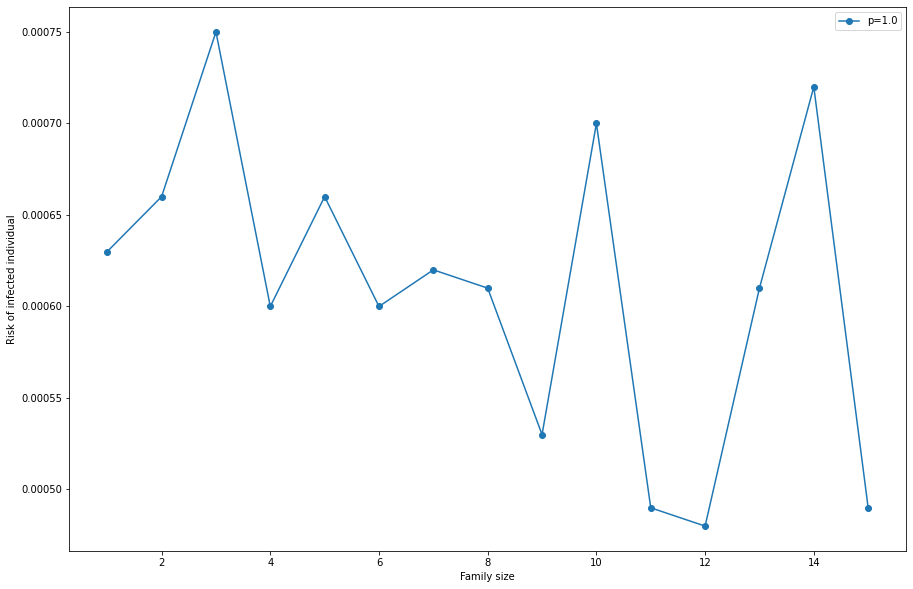

In [94]:
plt.figure(figsize=(15,10))
plt.plot(x,y,label="p="+str(i),marker='o')
plt.xlabel('Family size')
plt.ylabel('Risk of infected individual')
plt.legend()
plt.savefig('../images/test.png')
plt.show()


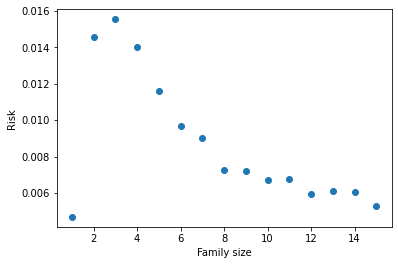

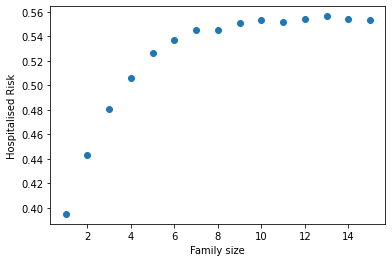

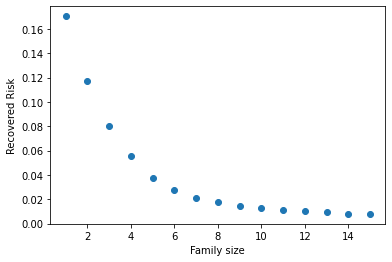

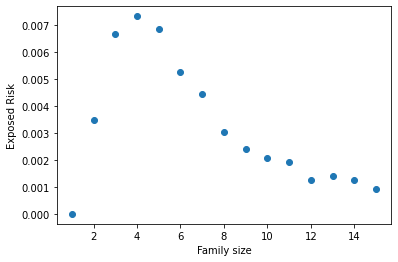

In [58]:
plt.scatter(fam_size,fam_i_risk)
plt.xlabel('Family size')
plt.ylabel('Risk')
plt.savefig('../images/Asymptomatic_with_testing_9_compartment_3.png')
plt.show()

plt.scatter(fam_size,fam_h_risk)
plt.xlabel('Family size')
plt.ylabel('Hospitalised Risk')
plt.show()

plt.scatter(fam_size,fam_r_risk)
plt.xlabel('Family size')
plt.ylabel('Recovered Risk')
plt.show()

plt.scatter(fam_size,fam_e_risk)
plt.xlabel('Family size')
plt.ylabel('Exposed Risk')
plt.show()

# After the Lockdown

After ending the 21 day lockdown, we have a certain fraction of families that risk having at least one asymptomatic infected individuals ($\approx 1\%$), a certain fraction that risk having at least one exposed individual ($\approx 0.5 \%$), and a certain fraction that risk having at least one recovered individual (from $\approx 35\%$ to $0.8 \%$ depending on family size). 

We have a distribution of family sizes for Delhi NCT `fam_dist` (Census 2011). The number of asymptomatic individuals that are injected back into the population is thus the nearest integer to `fam_i_risk[n] x fam_dist[n] x fam_mean_i[n]`, and likewise for recovered and exposed individuals.

In [ ]:
fam_i_risk = np.array(fam_i_risk)
fam_dist   = np.array(fam_dist)
fam_mean_i = np.array(fam_mean_i)

n_I_per_fam_size = np.nan_to_num(np.array(fam_i_risk*fam_dist*fam_mean_i)).astype('int64') # Integer array of infected/family size
n_E_per_fam_size = np.nan_to_num(np.array(fam_e_risk*fam_dist*fam_mean_e)).astype('int64') # Integer array of exposed/family size
n_R_per_fam_size = np.nan_to_num(np.array(fam_r_risk*fam_dist*fam_mean_r)).astype('int64') # Integer array of recovered/family size

total_IA0 = np.sum(n_I_per_fam_size)
total_E0  = np.sum(n_E_per_fam_size)
total_R0  = np.sum(n_R_per_fam_size)


I now have a total number of asymptomatic infected, exposed, and recovered individuals in the total population. I run a numerical simulation with these numbers.

#### Defining the numerical simulation

In [ ]:
def num_soln(pars,Cpars,pops,T_max):
    
    # N is the total population
    
    # Input parameters ####################
    
    E0  = pops[0]        # floats; Initial number of infected, exposed, and recovered individuals
    IP0 = pops[1]
    IA0 = pops[2]
    IS0 = pops[3]
    IM0 = pops[4]
    H0  = pops[5]
    R0  = pops[6]
    D0  = pops[7]
    N   = pops[8]
    
    S0 = N - IP0 - IA0 - IS0 - IM0 - H0 - D0 - R0 - E0        # float; Everyone else, S0, is susceptible to infection initially.
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    t = np.linspace(0, T_max, 10*T_max)# A grid of time points (in days)
    
    #########################################

    # The differential equations ############
    
    def deriv(y, t):
        S, E, IP, IA, IS, IM, H, R, D = y
        dSdt = -beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / N
        dEdt = +beta * S * (Cp*IP + Ca*IA + Cs*IS + Cm*IM) / N - gamma * E
        dIPdt= (1-alpha) * gamma * E  - lambdaP * IP
        dIAdt= alpha * gamma * E - lambdaA*IA
        dISdt= (1-mu) * lambdaP * IP - lambdaS * IS
        dIMdt=  mu * lambdaP * IP - lambdaM * IM
        dHdt = +lambdaS * IS - rho * H
        dRdt = lambdaM * IM + lambdaA * IA + (1-delta) * rho * H
        dDdt = delta * rho * H
        return dSdt, dEdt, dIPdt, dIAdt, dISdt, dIMdt, dHdt, dRdt, dDdt
    
    #########################################
    
    
    y0 = S0, E0, IP0, IA0, IS0, IM0, H0, R0, D0                               # Initial conditions vector
    
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, E, IP, IA, IS, IM, H, R, D = ret.T                                   # Return the transpose of the matrix

    return t, S/N, E/N, IP/N, IA/N, IS/N, IM/N, H/N, R/N, D/N

## Running the numerical simulation for 7 days 

In [ ]:
days = 7

pops = [total_E0,  0 , total_IA0 ,  0 ,  0 ,  0 , total_R0 ,  0 , totalPop]
     # [ E0,      IP0,   IA0,      IS0, IM0, IH0, R0,         D0,  N]

t, S, E, IP, IA, IS, IM, H, R, D = num_soln(pars,Cpars,pops,days)

# plt.plot(t,S)
# plt.plot(t,E)
# plt.plot(t,IP)
# plt.plot(t,IA)
# plt.plot(t,IS)
# plt.plot(t,IM)
# plt.plot(t,H)
# plt.plot(t,R)
# plt.plot(t,D)
# plt.show()

plt.plot(t,IA)
plt.xlabel('Days since lockdown')
plt.ylabel('Asymptomatic fraction of population')
plt.savefig('../images/Asymptomatics_after_lockdown_9_compartment_7days.png')
plt.show()

## Interesting! : The total number of infected asymptomatics reduces in the first seven days before increasing again!

# Next step: Reimposing a lockdown

Let's now consider what happens if we re-impose a lockdown after a week. At the end of the week with no lockdown, we have a number of susceptible, infected, etc. individuals as a fraction of the population. What do we do with them? Well, first, what are the fractions?

In [ ]:
p = np.array([E[-1],IP[-1], IA[-1], IS[-1], IM[-1], H[-1], R[-1], D[-1], 1.0])
            # [ pE0,  pIP0, pIA0,   pIS0,   pIM0,  pIH0,  pR0,    pD0,   pN]

print("Fraction of susceptible: "+ str(2 - np.sum(p)))
print("Fraction of exposed    : "+ str(p[0]))
print("Fraction of presymptoms: "+ str(p[1]))
print("Fraction of asymptomats: "+ str(p[2]))
print("Fraction of severe     : "+ str(p[3]))
print("Fraction of mild       : "+ str(p[4]))
print("Fraction of hospitalsed: "+ str(p[5]))
print("Fraction of recovered  : "+ str(p[6]))
print("Fraction of dead       : "+ str(p[7]))

print("\nSUM: "+str(pS + pE + pIA + pIP + pIS + pIM + pH + pR + pD))

So what I'm going to do now is select a family size at random from the family distribution, and for every member of the family I will check if they are infected, susceptible, etc. by using the above fractions as **probabilities** that the individual is indeed infected, susceptible, etc.

### Family size distribution

Let's start by first creating a distribution of family sizes for Delhi NCT from data `fam_dist` (Census 2011). We define a `get_fam()` function that returns an arbitrary family size satisfying the above distribution. To check that it works, we run it many times and see that it reproduces the original distribution.

In [ ]:
def get_fam():
    totalPop = np.sum(fam_dist)
    w = np.array(fam_dist)/totalPop
    num = np.zeros(len(fam_dist),int)
    r = np.random.random()

    if(r < w[0]):
        return 1
    else:
        add = w[0]
        for j in range(1,len(fam_dist)):
            add = add + w[j]
            if(r<add):
                return j+1
                break

In [ ]:
total_nums =[]
n_iter = 10000
for i in range(0,n_iter):
    total_nums.append(get_fam())
    
nn = np.zeros(15,int)
total_nums = np.array(total_nums)
for i in range(1,16):
    nn[i-1] = len(total_nums[total_nums==i])

plt.scatter(range(0,len(fam_dist)),nn/n_iter)
plt.scatter(range(0,len(fam_dist)),w,marker='x')
plt.savefig('../images/Delhi_NCT_population_dist.png')


So the plan is now to run a simulation a large number of times `n_iter = 100,000`, choose a family at random from the above distribution using `get_fam()`, for every member in that family assign if they are susceptible, infected, etc, according to the "probabilities" given above, run the Gillespie and compute the fraction of asymptomatics at the end.

In [ ]:
n_iter = 1000000

s_pops = np.zeros(len(p),float)

for i in range(0,n_iter):                  # Run the loop n_iter times
    N = get_fam()                          # Get a random family of size N according to the distribution
    
    pops = np.zeros(len(p),float)
    #print(N)
    for j in range(0,N):                   # For every member of the family
        r = random.uniform(0.0, 1.0)       # Generate a random number uniformly between 0 and 1
        
        if(r < p[0]):                      # If r < prob of exposed, increase n_exposed by 1
            pops[0]+=1
        else:
            add = p[0]
            for j in range(1,len(p)):
                add = add + p[j]
                if(r<add):
                    pops[j]+=1
                    break
    
    pops[len(pops)-1]=np.sum(pops)       # The last element is currently the number of Susceptibles but acccording
                                         # to my convention is should be N, which is why I set it to N here.
    s_pops=s_pops+pops                   # Array to check whether the proportions are the same
print(s_pops)

The `s_pops` array is just to verify that the fractions of E, IA, etc. after `n_iter` iterations are the same as the original fraction of the population, given in `p`.

In [ ]:
print("Total number of people: " + str(s_pops[-1]))
s_pops = s_pops/s_pops[-1]               # Make s_pops the fraction of population (divide by the last element N)

print((s_pops-p)/p * 100)                # Print the percentage difference between original and obtained fractions.
                                         # This is a sort of 'error', should become smaller with more runs.

This seems reasonably good. I can now convert the above code to include running the Gillespie in every loop.

In [ ]:
days = lockdown_days
# List of arrays to plot result ######
#fam_size = [] 
fam_i_risk = np.zeros(len(fam_dist))
fam_h_risk = np.zeros(len(fam_dist))
fam_r_risk = np.zeros(len(fam_dist))
fam_e_risk = np.zeros(len(fam_dist))

fam_mean_i = np.zeros(len(fam_dist))
fam_mean_r = np.zeros(len(fam_dist))
fam_mean_e = np.zeros(len(fam_dist))

#######################################

n_iter = 1000000

s_pops = np.zeros(len(p),float)

for i in range(0,n_iter):                  # Run the loop n_iter times
    N = get_fam()                          # Get a random family of size N according to the distribution
    
    pops = np.zeros(len(p),float)
    #print(N)
    for j in range(0,N):                   # For every member of the family
        r = random.uniform(0.0, 1.0)       # Generate a random number uniformly between 0 and 1
        
        if(r < p[0]):                      # If r < prob of exposed, increase n_exposed by 1
            pops[0]+=1
        else:
            add = p[0]
            for j in range(1,len(p)):
                add = add + p[j]
                if(r<add):
                    pops[j]+=1
                    break
    
    pops[len(pops)-1]=np.sum(pops)       # The last element is currently the number of Susceptibles but acccording
                                         # to my convention is should be N, which is why I set it to N here.
    s_pops=s_pops+pops                   # Array to check whether the proportions are the same
    
    # Run the Gillespie ##########################
    
    time_survived = []
    no_of_asymp   = []
    no_of_hosp    = []
    no_of_rec     = []
    no_of_exp     = []
    
    t,S,E,IP,IA,IS,IM,H,R,D = Gil(pars,Cpars,pops,days)# Assuming 1 exposed individual initially
    time_survived.append(t[-1])                        # Take last element of time array (the time survived)
    no_of_asymp.append(IA[-1])                         # Take last element of IA (the final number of asymptomatics)
    no_of_hosp.append(H[-1])
    no_of_rec.append(R[-1])
    no_of_exp.append(E[-1])

    time_survived = np.array(time_survived)
    no_of_asymp   = np.array(no_of_asymp)
    no_of_hosp    = np.array(no_of_hosp)
    no_of_rec     = np.array(no_of_rec)
    no_of_exp     = np.array(no_of_exp)
    
    
    non_zero_asymp = no_of_asymp[no_of_asymp!=0]  # Consider only those runs where there are 
                                                  # non-zero asymptomatics
    non_zero_hosp  = no_of_hosp[no_of_hosp!=0]
    non_zero_rec   = no_of_rec[no_of_rec!=0]
    non_zero_exp   = no_of_exp[no_of_exp!=0]
    
    #fam_size.append(i)                            # Set of family sizes
    fam_i_risk[N-1]+=(len(non_zero_asymp)/n_iter) # Total number of asymptomatics (length of non_zero_asymp) per iteration
    fam_h_risk[N-1]+=(len(non_zero_hosp)/n_iter)
    fam_r_risk[N-1]+=(len(non_zero_rec)/n_iter)
    fam_e_risk[N-1]+=(len(non_zero_exp)/n_iter)
    
    fam_mean_i[N-1]+=(np.mean(non_zero_asymp))
    fam_mean_r[N-1]+=(np.mean(non_zero_rec))
    fam_mean_e[N-1]+=(np.mean(non_zero_exp))

    

In [ ]:
plt.scatter(fam_size,fam_i_risk)
plt.xlabel('Family size')
plt.ylabel('IA Risk after 2nd lockdown')
plt.ylim(0,0.001)
plt.savefig('../images/9_compartment_second_lockdown_iA_1.png')
plt.show()

plt.scatter(fam_size,fam_h_risk)
plt.xlabel('Family size')
plt.ylabel('Hospitalised Risk')
plt.show()

plt.scatter(fam_size,fam_r_risk)
plt.xlabel('Family size')
plt.ylabel('Recovered Risk')
plt.show()

plt.plot(fam_size,fam_e_risk)
plt.xlabel('Family size')
plt.ylabel('Exposed Risk')
plt.show()

In [15]:
print(np.random.uniform())

0.7852523750367908
